# Signal transforms and filters

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

## Introduction

- In this lecture, we will get a basic understanding of the Fourier Transform (FT), Discrete Fourier Transform (DFT), and learn how any function can be approximated by a series of sines and cosines. 
- In particular, we will learn the FT of common signals, the main properties of FT, and the practical skills needed to apply the FT.
- In addition, we will see some common filters and learn why they are useful to process time series data. 
- Finally, we will see how FT can be useful in forecasting tasks.

In [1]:
import sys

# Install dependencies if the notebook is running in Colab
if 'google.colab' in sys.modules:
    !pip install -U -qq tsa-course

In [2]:
# Imports
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from IPython.display import YouTubeVideo
import numpy as np
import pandas as pd
from scipy import signal
from scipy.integrate import cumulative_trapezoid
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from tsa_course.lecture2 import run_sequence_plot
from tsa_course.lecture8 import annotated_sin_plot

---

## Fourier Transform

- The idea behind the Fourier Transform is that any time signal can be decomposed into a sum of sinusoids that have different amplitude, frequencies, and phases.
- Let's start from the definition of a **sine wave**.

- A sine wave is mathematical curve that describes smooth periodic oscillations.
- It is continuous and is described by: 

$$y(t) = A \sin (2 \pi f t + \psi) = A \sin (\omega t + \psi)$$ 

- where $A$ is the amplitude, $f$ is the frequency, and $\psi$ is the phase in radians.

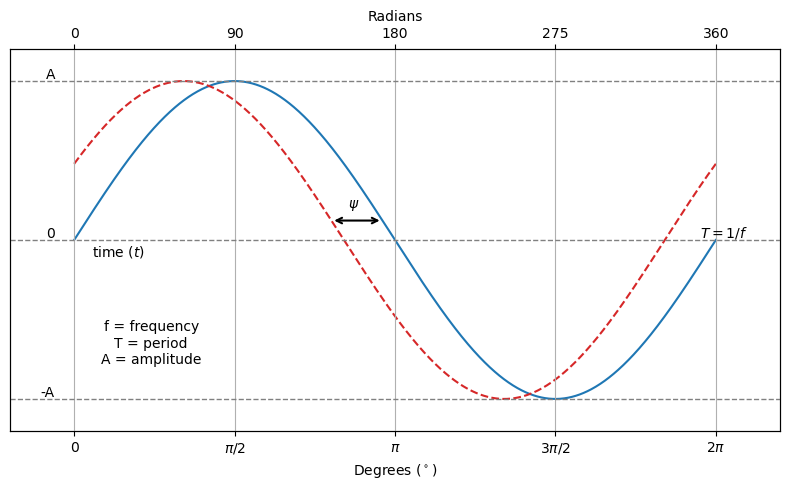

In [3]:
annotated_sin_plot()

- The FT decomposes a time signal into the sum of sines with varying amplitudes, frequencies, and phases.
- The sines represent the constituent frequencies of the original signal.
- As such, FT gives the frequency domain representation of the original signal.

<img src="media/ft.png" style="width: 45%; display: block; margin: auto;">

The Fourier Transform mathematical formulation is given by:

\begin{equation}\mathcal{F}(\omega) = \int_{-\infty}^{\infty} f(t) e^{-i \omega t} dt \end{equation}

- where:
    - $t$ is time,
    - $f(t)$ is a continuous time signal,
    - $\mathcal{F}(\omega)$ is the Fourier Transform of $f(t)$,
    - $f(t)$ is the original time-domain function (signal),
    - $\omega = 2\pi f$ is the angular frequency,
    - $e$ is the base of the natural logarithm,
    - $i$ is the imaginary unit, satisfying $i^2 = -1$.

**Explanation**

- The term $e^{-i \omega t}$ is a complex exponential.
- It can be expressed as $e^{-i \omega t} = \cos(\omega t) -i \sin(\omega t)$.
- $e^{-i \omega t}$ can be thought of as a rotating vector (phasor) in the complex plane, where $\omega$ dictates the speed of rotation and $t$ represents time.

- The integral over time indicates that the transformation considers all points in time from $-\infty$ to $+\infty$, giving a complete representation of the signal in the frequency domain. 
- Since we cannot deal with infinity, various approximations are used in practice.

- The result of the Fourier Transform is a complex function of frequencies.
- It shows how much of each frequency is present in the original signal. 
- The *magnitude* of $\mathcal{F}(\omega) = \mathcal{F}(2\pi f)$ indicates the amplitude of a particular frequency component $f$.

- The intuitive interpretation of Eq.1 is that the effect of multiplying $f(t)$ by  $e^{-i\omega t}$ is to subtract $\omega$ from every frequency component of $f(t)$.
- Only the components of $f(t)$ that have frequency $\omega$ can produce a non-zero value of the infinite integral.
- All the other shifted components are oscillatory and integrate to zero.

### Inverse Fourier Transform

$$ f(t) = \int_{-\infty}^{\infty} \mathcal{F}(\omega) e^{i \omega t} d \omega $$

- The inverse Fourier Transform expresses a signal $f(t)$ as a weighted summation of complex exponential functions.
- The formula is very similar to FT.
- It shows us that *any* function can be expressed as a combination of sinusoids.
- The sinusoids represent, thus, a *basis*.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bd/Fourier_series_square_wave_circles_animation.svg" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%">Image: <a href="https://commons.wikimedia.org/wiki/File:Fourier_series_square_wave_circles_animation.svg#filelinks">Wikimedia</a></div>

---

## Discrete Fourier Transform and Fast Fourier Transform

- The Discrete Fourier Transform (DFT) converts a finite list of equally spaced *samples of a function* into a finite list of *coefficients of complex sinusoids*, ordered by their frequencies. 
- The Fast Fourier Transform (FFT) is an algorithm designed to compute the DFT and its inverse efficiently.

- The FFT significantly reduces the computational complexity of performing a DFT from $\mathcal{O}(N^2)$ to $\mathcal{O}(N \log N)$, where $N$ is the number of samples.
- This efficiency gain is particularly impactful for large datasets, making the FFT an indispensable tool in digital signal processing, image analysis, fast convolution, and various fields of engineering and applied science.

### Basic Idea

- The DFT for a sequence $x[n]$ of length $N$ is defined as follows:

$$X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-\frac{i 2 \pi}{N} k n}$$

- for $k = 0, 1, \ldots, N-1$, where $X[k]$ are the frequency domain samples.
- The FFT exploits the symmetry and periodicity properties of the complex exponential function.
- It applies a divide-and-conquer strategy to decompose the DFT of a sequence into smaller DFTs, reducing the overall computational effort.

This [video](https://youtu.be/QmgJmh2I3Fw) gives an excellent introduction to DFT.

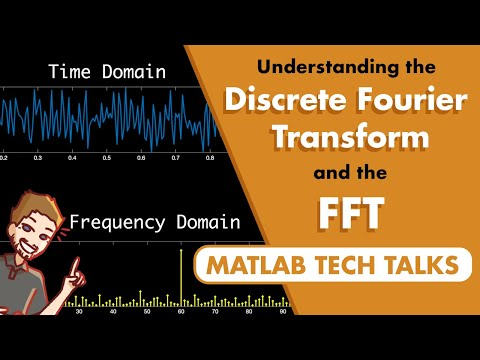

In [4]:
YouTubeVideo('QmgJmh2I3Fw', width=560, height=315)

### Cooley-Tukey Algorithm

- The most well-known FFT algorithm is the Cooley-Tukey algorithm. 
- It recursively divides the DFT of a sequence into two, by separating the sequence into even and odd elements: 

$$X[k] = X_{\text{even}}[k] + e^{-\frac{i 2 \pi}{N} k} X_{\text{odd}}[k] $$ 

- and 

$$X \left[ k + \frac{N}{2} \right] = X_{\text{even}}[k] - e^{-\frac{i 2 \pi}{N} k} X_{\text{odd}}[k]$$

- This process is repeated on the subsequences until the problem is reduced to the DFT of sequences of length 1, which are trivial. 
- The algorithm recombines these results to produce the final DFT.

---

## Common Fourier Transforms

- First, we make a list of the most common FT of known functions and report their analytic expression.
- This list is adapted from [here](https://github.com/cpjobling/eg-247-textbook).

|     | **Name**                         | $f(t)$                            | $F(\omega)$ | **Remarks**                           |
|-----| ---------------------------------|-----------------------------------|-------------|---------------------------------------|
| 1.  | Dirac delta                      | $\delta(t)$                       | $1$         | Constant energy at *all* frequencies. |
| 2.  | Time sample                      | $\delta(t-t_0)$                   |  $e^{-i\omega t_0}$ |  
| 3.  | Phase shift                      | $e^{i\omega_0 t}$                 |  $2\pi\delta(\omega - \omega_0)$ |  
| 4.  | *Signum*                         | $\operatorname{sgn} t$            |  $\displaystyle{\frac{2}{i\omega}}$ | Also known as sign function
| 5.  |  Unit step                       | $u(t)$                            |  $\displaystyle{\frac{1}{i\omega}+\pi\delta(\omega)}$ |  
| 6.  |  Cosine                          | $\cos \omega_0 t$                 |  $\pi\left[\delta(\omega-\omega_0)+\delta(\omega+\omega_0)\right]$ |  
| 7.  |  Sine                            | $\sin \omega_0 t$                 |  $-i\pi\left[\delta(\omega-\omega_0)-\delta(\omega+\omega_0)\right]$ |  
| 8.  |  Single pole                     | $e^{-at}u_0(t)$                   |  $\displaystyle{\frac{1}{i\omega + a}}$ |  $a \gt 0$ |
| 9.  |  Double pole                     | $te^{-at}u_0(t)$                  |  $\displaystyle{\frac{1}{(i\omega + a)^2}}$ |  $a \gt 0$ |
| 10. |  Complex pole (cosine component) | $e^{-at}\cos \omega_0 t\;u_0(t)$  |  $\displaystyle{\frac{i\omega + a}{(i\omega + a)^2+\omega_0^2}}$ |  $a\gt 0$
| 11. |  Complex pole (sine component)   | $e^{-a t}\sin \omega_0 t\;u_0(t)$ |  $\displaystyle{\frac{\omega_0}{(i\omega + a)^2+\omega_0^2}}$ |  $a\gt 0$ |



- Next, we provide some examples of the approximation given by FFT.
- We'll mainly use three functions:
    - `fft(y)`: Computes the FFT $F(\omega)$ of a time signal $y=f(t)$.
    - `fftfreq(n, d)`: Returns the Discrete Fourier Transform sample frequencies $\omega$; `n` is the windows length and `d` is the sample spacing (inverse of the sampling rate $f=1/T$).
    - `fftshift(x)`: Shifts the zero-frequency component to the center of the spectrum: `[ 0.,  1.,  2., ..., -3., -2., -1.] --> [-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.]`

In [5]:
# Convenience function that creates both a time domain and frequency domain plot.
def plot_time_freq(t, y):
    # Converts Data into Frequncy Domain
    freq = np.fft.fftfreq(t.size, d=t[1]-t[0])
    Y = abs(np.fft.fft(y))
    
    # Time domain plot
    plt.figure(figsize = [14,3])
    plt.subplot(1,2,1)
    plt.plot(t,y)
    plt.title('Time Domain')
    plt.xlabel('Time')
    plt.ylabel('Signal')
    
    # Frequency domain plot
    plt.subplot(1,2,2)
    markerline, stemline, baseline = plt.stem(np.fft.fftshift(freq),np.fft.fftshift(Y),
                                              'k', markerfmt='tab:orange')
    plt.setp(stemline, linewidth = 1.5)
    plt.setp(markerline, markersize = 4)
    plt.title('Frequency Domain')
    plt.xlabel('Frequency')
    plt.xlim(-20, 20)
    plt.ylabel('Absolute FFT')
    plt.grid()

    plt.tight_layout()
    plt.show()

### Sine


|     | Time              | Frequency                                                            |
|:---:|:-----------------:|:--------------------------------------------------------------------:|
|Sine | $\sin \omega_0 t$ |  $-i\pi\left[\delta(\omega-\omega_0)-\delta(\omega+\omega_0)\right]$ |  


Let's start by creating a time series that consists of a sine wave with a frequency of $1 Hz$.

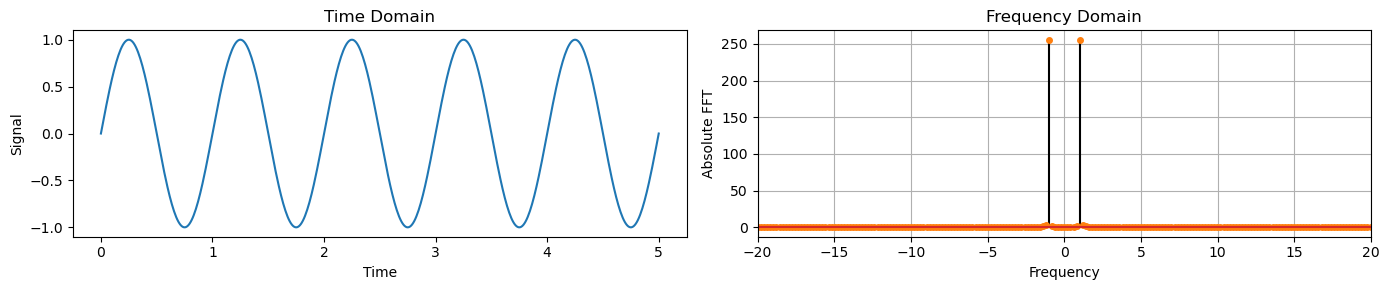

In [6]:
freq = 1 # Hz
time = np.linspace(0, 5, 512)
y_sine = np.sin(2 * np.pi * freq * time)
plot_time_freq(time, y_sine)

- We can observe that in the frequency domain there are 2 spikes at $+1Hz$ and $-1Hz$.  
- This indicates the frequency of the sine wave.  
- Note that there is a symmetry between the left and right side across the $0 Hz$ frequency.

- Next, we change the frequency to $10Hz$ and we observe that the peaks in the frequency domain are now located at the $\pm 10 Hz$.

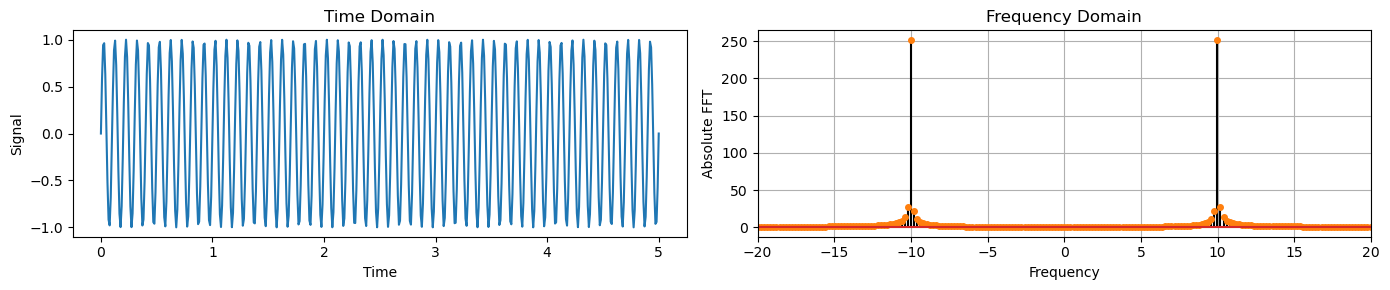

In [7]:
freq = 10
y_sine = np.sin(2 * np.pi * freq * time)
plot_time_freq(time, y_sine)

### Dirac delta

|   | Time | Frequency |
|:-:|:----:|:---------:|
|Constant | 1| $2 \pi \delta(\omega)$ |
| Dirac delta | $\delta(t)$ | 1 |

- Constant values in time correspond to a Dirac delta a frequency at 0 Hz.  
- For example, a constant equal to 1 in the time domain, creates to a spike at 0Hz in the frequency domain.

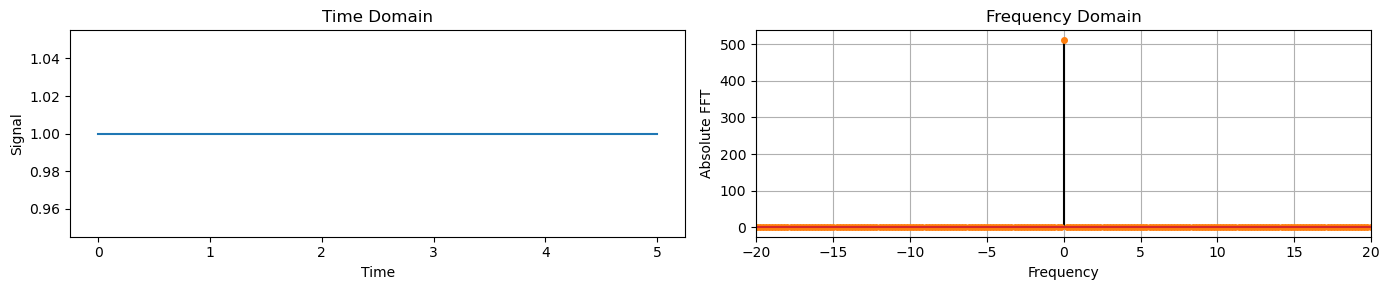

In [8]:
# Data set in Time Domain
y_constant = np.ones(time.shape)

plot_time_freq(time, y_constant)

- Similarly, a Dirac delta in time corresponds to a constant in the frequency domain.

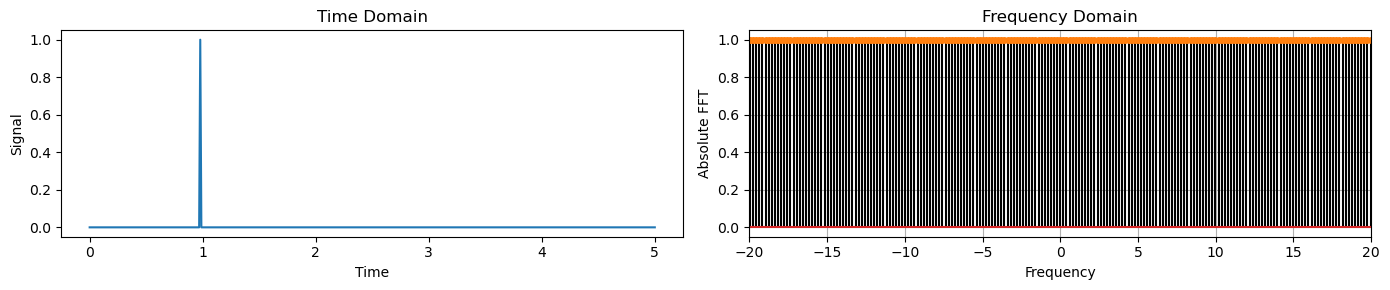

In [9]:
y_delta = np.zeros(time.shape)
y_delta[100] = 1

plot_time_freq(time, y_delta)

### Unit step

|           | Time   | Frequency                                              |
|:---------:|:------:|:------------------------------------------------------:|
| Unit step | $u(t)$ | $\frac{1}{i\omega} + \pi\delta(\omega)$ |  

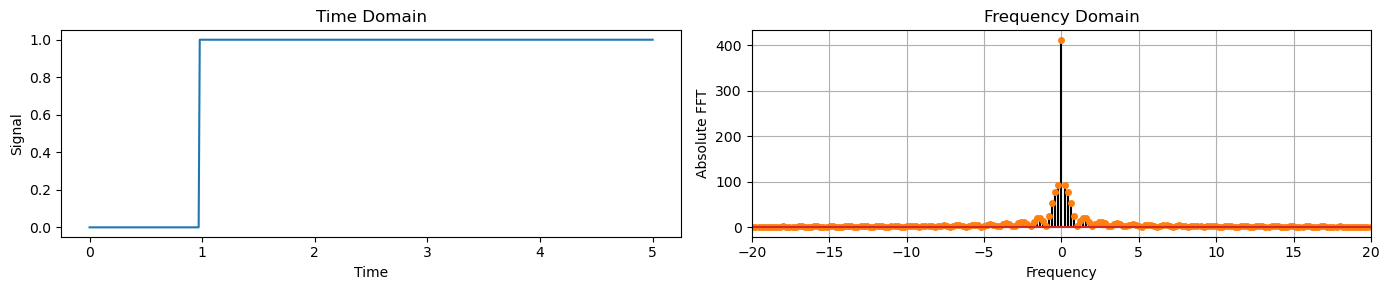

In [10]:
y_step = np.zeros(time.shape)
y_step[100:] = 1

plot_time_freq(time, y_step)

### Sinc

|   | Time | Frequency |
|:-:|:----:|:---------:|
|Sinc | $\frac{\sin(A t)}{\pi t}$ | $\begin{cases} 1, & \|\omega\| < A \\ 0 & \text{otherwise} \end{cases}$ |



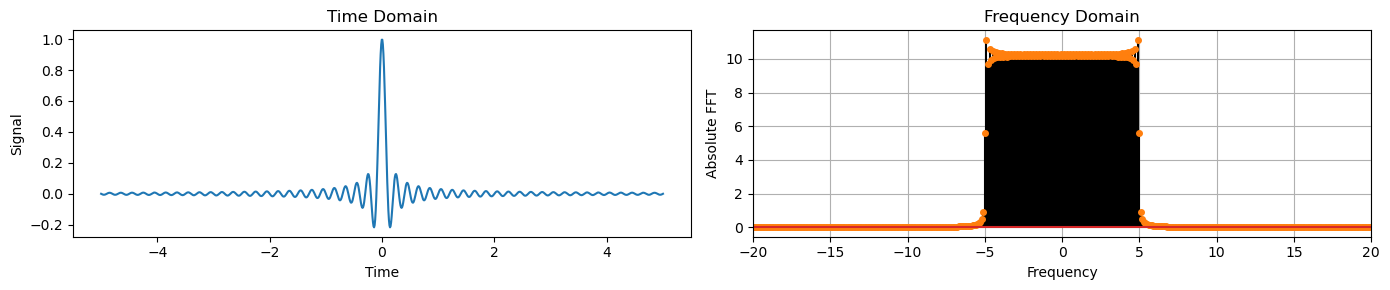

In [11]:
time = np.linspace(-5, 5, 1024)
freq=5
y_sinc = np.sin(2 * np.pi * freq * time) / (2 * np.pi * freq * time)
plot_time_freq(time, y_sinc)

### Signal with trend and noise

Next we will analyze a signal that contains:
* A sine wave representing seasonality,
* a parabolic function representing a trend,
* and uniformly distributed random noise.

Below we create and plot each of the components separately.

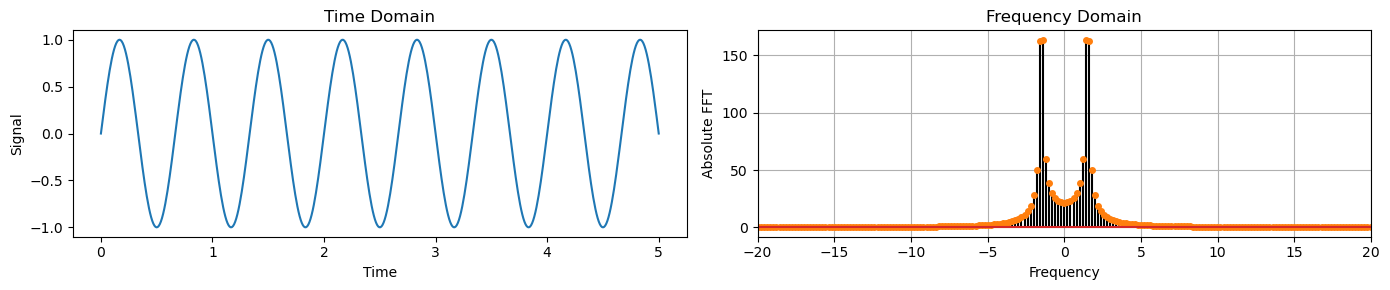

In [12]:
time = np.linspace(0, 5, 512)
freq = 1.5

y_sine = np.sin(2 * np.pi * freq * time)
plot_time_freq(time, y_sine)

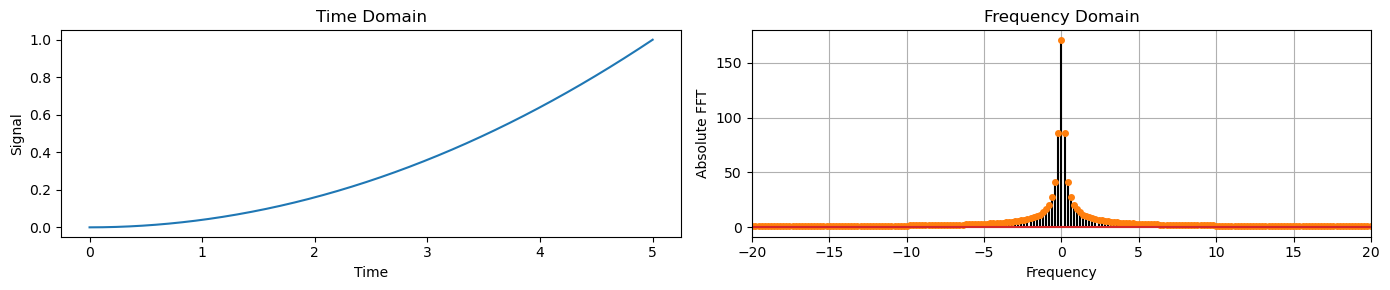

In [13]:
y_trend = (0.2 * time)**2
plot_time_freq(time, y_trend)

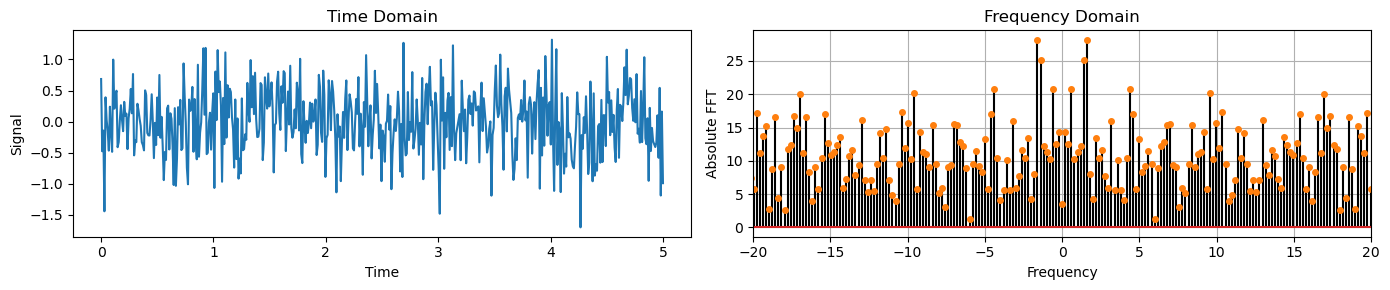

In [14]:
y_noise = 0.5 * np.random.randn(len(time))
plot_time_freq(time, y_noise)

We can observe that in the Frequency Domain: 
1. The sine wave has components at -1.5 and +1.5. 
2. The trend has low frequency components (close to 0). 
3. The noise has components across all frequencies.

---

## Spectral leakage

- Let's define a sampling frequency and time vector that defines the length of our signal.
- The *Fundamental frequency resolution* is given by $\frac{\text{Sampling frequency}}{\text{Number of points in FFT}}$.

In [15]:
Fs = 1234     # Sampling frequency in Hz
duration = 4  # seconds
t = np.arange(0, duration, 1/Fs)  # Time vector
print(f"Fundamental frequency resolution: {Fs/len(t):.2f}")

Fundamental frequency resolution: 0.25


- When you apply the FFT to a signal, you're usually looking at it through a "window" of a specific length. 
- If the signal's waveform doesn't complete a whole number of cycles within this window, the edges of the window essentially "cut off" part of the waveform. 
- The FFT assumes the signal outside this window is zero, which is rarely true for real signals. 
- This "cutting" makes the waveform look different from its true form, leading to inaccuracies in the frequency domain representation.

- In particular, if the signal's frequency components do not align exactly with the FFT's frequency bins, we observe a phenomenon called *spectral leakage*.
- What happens is that the energy of the signal gets spread across multiple bins around the true frequency.
- Let's show it with an example where we sum two sinusoids:
    - The first has a frequency multiple of the fundamental frequency resolution, the second hasn't. 

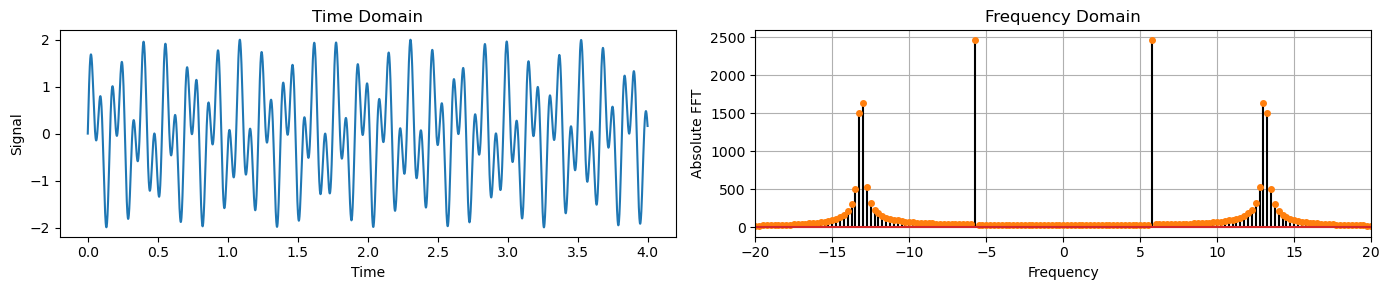

In [16]:
freq1 = 5.75   # Frequencies of the 1st sinusoid in Hz
freq2 = 13.12  # Frequencies of the 2nd sinusoid in Hz

y_sine = np.sin(2 * np.pi * freq1 * t) + np.sin(2 * np.pi * freq2 * t)
plot_time_freq(t, y_sine)

- For the second component, we observe a many small non-zero frequencies around the acutal one, `13.12`.
- This is the *spectal leakage*.
- This is a very common phenomenon when analyzing real-world signals.
- We should keep this in mind when we try to isolate specific frequencies with filters (more on this later).

---

## Properties of the Fourier transform

### Linearity

- The FT is linear, meaning that the transform of a sum of signals is the sum of their transforms. 
- Mathematically, for any two signals $f(t)$ and $g(t)$, and any constants $a$ and $b$, this property is expressed as: 

$$\mathcal{F}\{a f(t) + b g(t)\} = a \mathcal{F}\{f(t)\} + b \mathcal{F}\{g(t)\}$$

- This property allows for the analysis of complex signals by breaking them down into simpler components.

In [17]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
f1 = 50  # Frequency of sine wave in Hz
f2 = 80  # Frequency of cosine wave in Hz
a, b = 2, 3  # Constants

f_t = np.sin(2 * np.pi * f1 * t) # First function
g_t = np.cos(2 * np.pi * f2 * t) # Second function
combination = a * f_t + b * g_t # Linear combination of the functions

F_f_t = np.fft.fft(f_t) # FT of the first function
F_g_t = np.fft.fft(g_t) # FT of the second function
linear_combination_F = a * F_f_t + b * F_g_t # Linear combination of the FTs
F_combination = np.fft.fft(combination) # FT of the linear combination

In [18]:
def plot_linearity(t, f_t, g_t, combination, F_combination, linear_combination_F):
    freq = np.fft.fftfreq(t.size, d=t[1]-t[0])
    plt.figure(figsize=(14, 6))

    plt.subplot(2, 2, 1)
    plt.plot(t, f_t, label='$f(t)$')
    plt.plot(t, g_t, label='$g(t)$')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Original Functions $f(t)$ and $g(t)$')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(t, combination, label='Linear Combination')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.title('Linear Combination in Time Domain')
    plt.legend()

    plt.subplot(2, 2, 3)
    plt.stem(np.fft.fftshift(freq), np.fft.fftshift(np.abs(F_combination)), 'k', markerfmt='tab:blue')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('FT of Linear Combination')
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.stem(np.fft.fftshift(freq), np.fft.fftshift(np.abs(linear_combination_F)), 'k', markerfmt='tab:orange')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Linear Combination of FTs')
    plt.grid()

    plt.tight_layout()
    plt.show()

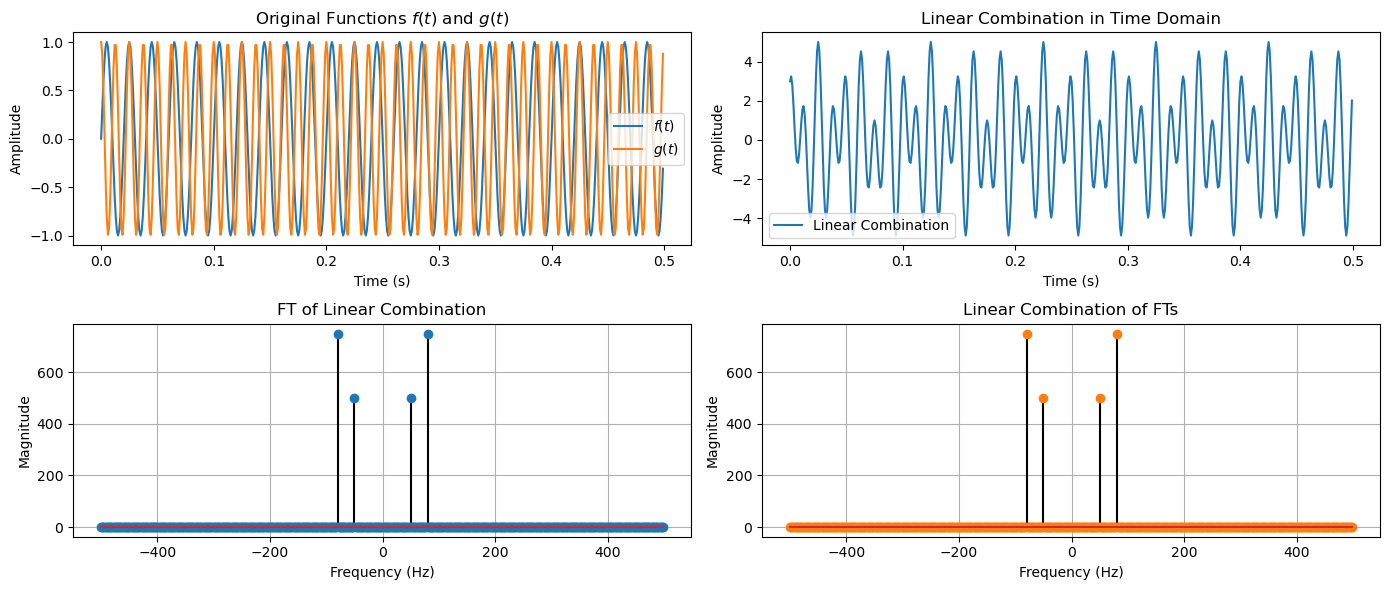

In [19]:
plot_linearity(t, f_t, g_t, combination, F_combination, linear_combination_F)

### Time shift

- Shifting a signal in time results in a phase shift in its Fourier Transform. 
- If $f(t - t_0)$ is a time-shifted version of $f(t)$, its Fourier Transform is:

$$\mathcal{F}\{f(t - t_0)\} = e^{-i \omega t_0} \mathcal{F}\{f(t)\}$$

- This property shows that time delays correspond to phase shifts in the frequency domain, without affecting the amplitude of the frequency components.

In [20]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
f0 = 50  # Frequency of sine wave in Hz
t0 = 0.01  # Time shift in seconds

# Define the function and its time-shifted version
f_t = np.sin(2 * np.pi * f0 * t)
f_t_shifted = np.sin(2 * np.pi * f0 * (t - t0))

# Compute Fourier Transforms
F_f_t = np.fft.fft(f_t)
F_f_t_shifted = np.fft.fft(f_t_shifted)

In [21]:
def plot_time_shift(t, f_t, f_t_shifted, F_f_t, F_f_t_shifted):

    frequencies = np.fft.fftfreq(t.size, d=t[1]-t[0])
    plt.figure(figsize=(14, 6))

    # Functions in time domain
    plt.subplot(2, 1, 1)
    plt.plot(t, f_t, label='$f(t)$')
    plt.plot(t, f_t_shifted, label='$f(t - t_0)$')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Magnitude of Fourier Transform
    plt.subplot(2, 2, 3)
    plt.stem(frequencies, np.abs(F_f_t),'k', markerfmt='tab:blue', label='Original')
    plt.stem(frequencies, np.abs(F_f_t_shifted),'k', markerfmt='tab:orange', label='Shifted')
    plt.title('Magnitude of $F(\omega)$')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()

    # Phase of Fourier Transform before and after shift
    plt.subplot(2, 2, 4)
    plt.stem(frequencies, np.angle(F_f_t+1e-10),'k', markerfmt='tab:blue', label='Original')
    plt.stem(frequencies, np.angle(F_f_t_shifted+1e-10),'k', markerfmt='tab:orange', label='Shifted')
    plt.title('Phase of $F(\omega)$')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

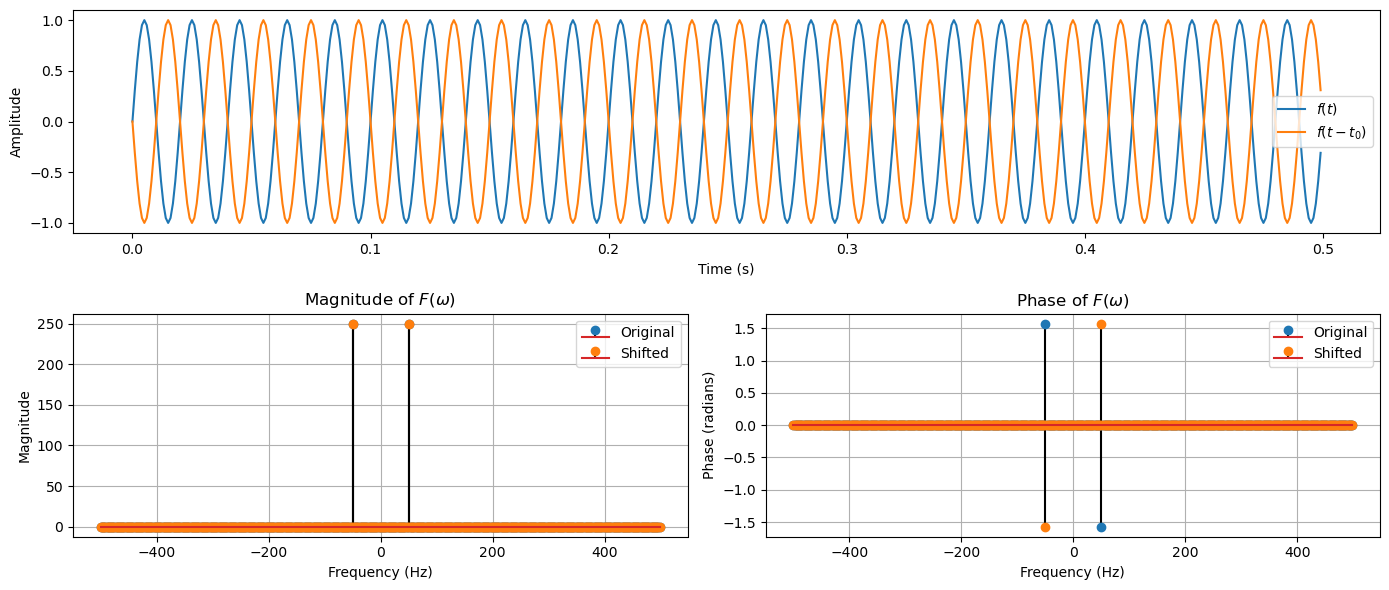

In [22]:
plot_time_shift(t, f_t, f_t_shifted, F_f_t, F_f_t_shifted)

### Frequency shift

- Modulating a signal by a sinusoid results in a shift in the frequency domain. 
- If $g(t) = e^{i 2 \pi f_0 t} f(t)$, then the Fourier Transform of $g(t)$ is:

$$ \mathcal{F}\{g(t)\} = \mathcal{F}(\omega - 2\pi f_0)$$

- This property is used in modulation schemes in communications.

In [23]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
f_signal = 50  # Frequency of the original signal in  Hz
f_shift = 30  # Frequency shift in Hz

f_t = np.sin(2 * np.pi * f_signal * t) # Original signal
f_shifted_t = np.exp(1j * 2 * np.pi * f_shift * t) * f_t # Frequency-shifted signal

# Compute Fourier Transforms
F_f_t = np.fft.fft(f_t)
F_shifted_t = np.fft.fft(f_shifted_t)

In [24]:
def plot_freq_shift(t, f_t, f_shifted_t, F_f_t, F_shifted_t):

    frequencies = np.fft.fftfreq(t.size, d=t[1]-t[0])
    plt.figure(figsize=(14, 3))

    # Functions in time domain
    plt.subplot(1, 2, 1)
    plt.plot(t, f_t, label='$f(t)$')
    plt.plot(t, f_shifted_t, label='$e^{i 2 \pi f_0 t} f(t)$')
    plt.title('Time Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Magnitude of the original signal's Fourier Transform
    plt.subplot(1, 2, 2)
    plt.stem(frequencies, np.abs(F_f_t),'k', label='$\mathcal{F}(\omega)$', markerfmt='tab:blue')
    plt.stem(frequencies, np.abs(F_shifted_t),'k', label='$\mathcal{F}(\omega - 2\pi f_0)$', markerfmt='tab:orange')
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

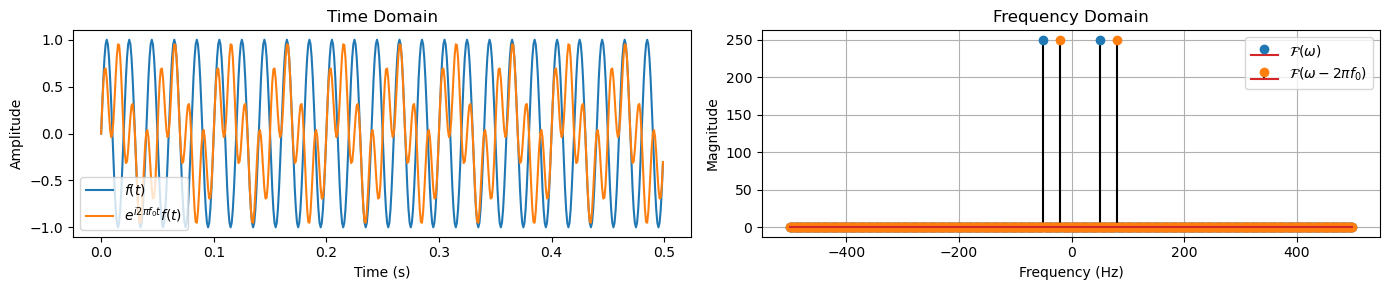

In [25]:
plot_freq_shift(t, f_t, f_shifted_t, F_f_t, F_shifted_t)

### Scaling

- Let $f(at)$ be a scaled version of $f(t)$, where $a$ is a real non-zero scaling factor. 
- Its Fourier Transform is scaled in the frequency domain by $1/|a|$ and is given by:

$$\mathcal{F}\{f(at)\} = \frac{1}{|a|}F\left(\frac{\omega}{a}\right)$$

- This property indicates that compressing a signal in time domain expands its spectrum in the frequency domain, and vice versa.

In [26]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
f0 = 50  # Frequency of the original signal in Hz
a = 2 # scaling factor

f_t = np.sin(2 * np.pi * f0 * t) # Original signal
f_scaled = np.sin(2 * np.pi * (f0/a) * t) # Scaled signal

# Compute Fourier Transforms
F_f_t = np.fft.fft(f_t)
F_scaled_t = np.fft.fft(f_scaled)

In [27]:
def plot_scaling(t, f_t, f_scaled, F_f_t, F_scaled_t):

    frequencies = np.fft.fftfreq(t.size, d=t[1]-t[0])
    plt.figure(figsize=(14, 3))

    # Functions in time domain
    plt.subplot(1, 2, 1)
    plt.plot(t, f_t, label='$f(t)$')
    plt.plot(t, f_scaled, label='$f(at)$')
    plt.title('Time Domain')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()

    # Magnitude of the original signal's Fourier Transform
    plt.subplot(1, 2, 2)
    plt.stem(frequencies, np.abs(F_f_t), 'k', label='$\mathcal{F}(\omega)$', markerfmt='tab:blue')
    plt.stem(frequencies, np.abs(F_scaled_t), 'k', label='$1/|a|F(\omega/a)$', markerfmt='tab:orange')
    plt.title('Frequency Domain')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

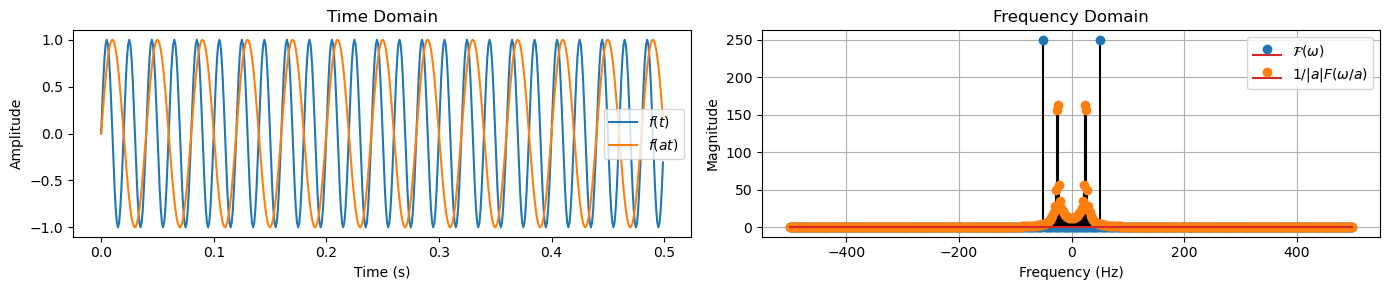

In [28]:
plot_scaling(t, f_t, f_scaled, F_f_t, F_scaled_t)

### Convolution

- Informally, convolution represents how much one function $f$ overlaps with another function $g$ as it slides across the domain.
- The Fourier transform converts convolution in time domain into multiplication in frequency domain. 
- The convolution is defined as:

$$f(t) * g(t) = \int \limits_{-\infty}^{\infty} f(\tau)g(t -\tau) d\tau$$

<img src="https://upload.wikimedia.org/wikipedia/commons/archive/6/6e/20100707184430%21Convolution_of_box_signal_with_itself.gif" style="width: 40%; display: block; margin: auto;">

<img src="https://upload.wikimedia.org/wikipedia/commons/archive/6/67/20100707184106%21Convolution_of_spiky_function_with_box.gif" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Image: <a href="https://en.wikipedia.org/wiki/Convolution">Wikipedia</a></div>


- If two functions $f(t)$ and $g(t)$ are convolved, their Fourier transforms are multiplied:

$$\mathcal{F}\{f(t) * g(t)\} = \mathcal{F}\{f(t)\} \cdot \mathcal{F}\{g(t)\}$$

In [29]:
Fs = 1000  # Sampling frequency in Hz
T = 1  # Length of signal in seconds
t = np.arange(-T, T, 1/Fs)  # Time vector
y1 = np.sin(2 * np.pi * 5 * t) # first signal
y2 = np.exp(-t ** 2) # second signal

# convolution in the time domain
convolution_time = np.convolve(y1, y2, mode='full') 

# Pad the signals with N-1 zeros to avoid circular convolution
y1_pad = np.pad(y1, (0, t.size-1), 'constant')
y2_pad = np.pad(y2, (0, t.size-1), 'constant')

# Compute the Fourier Transforms
Y1 = np.fft.fft(y1_pad)
Y2 = np.fft.fft(y2_pad)

# Multiplication in frequency domain and inverse transform
convolution_freq_domain = np.fft.ifft(Y1 * Y2)

In [30]:
def plot_convolution(t, y1, y2, convolution_time, convolution_freq_domain):
    fig, axs = plt.subplots(1, 3, figsize=(14, 3))

    # Original signals
    axs[0].plot(t, y1, label='Signal 1')
    axs[0].plot(t, y2, label='Signal 2')
    axs[0].legend()

    # Convolution in the time domain
    axs[1].plot(convolution_time)
    axs[1].set_title('Convolution in Time Domain')

    # Result of multiplication in the frequency domain (i.e., convolution result)
    axs[2].plot(convolution_freq_domain)
    axs[2].set_title('Result from Frequency Domain Multiplication')

    plt.tight_layout()
    plt.show()

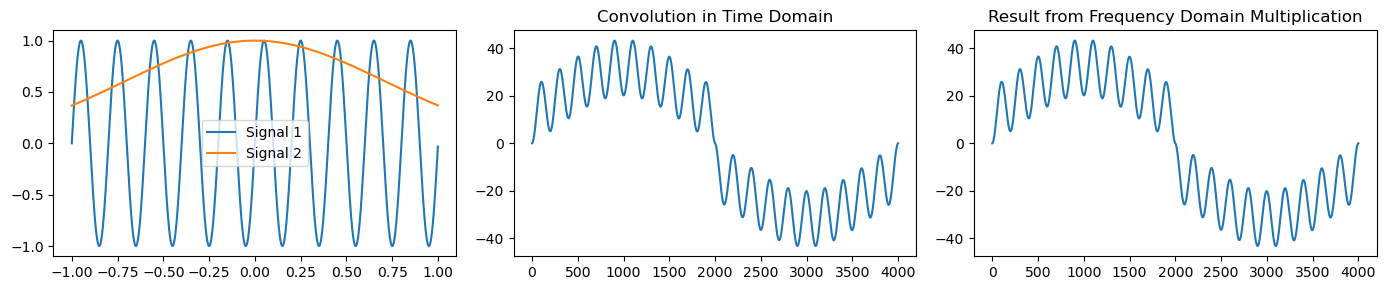

In [31]:
plot_convolution(t, y1, y2, convolution_time, convolution_freq_domain)

### Differentiation

- The FT of the derivative of a function is proportional to the frequency times the FT of the function itself:

$$ \mathcal{F}\{f'(t)\} = i\omega \mathcal{F}\{f(t)\}$$

- Conversely, the inverse FT of $\frac{d^n F(\omega)}{d\omega^n}$ is given by the multiplication of $f(t)$ by $(it)^n$, where $n$ is the order of differentiation:

$$\mathcal{F}^{-1}\left\{\frac{d^n F(\omega)}{d\omega^n}\right\} = (it)^n f(t)$$

In [32]:
Fs = 1000  # Sampling frequency in Hz
T = 1  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector
y = np.sin(2 * np.pi * 5 * t) + 0.5 * np.cos(2 * np.pi * 10 * t) # Signal

dy_dt_numerical = np.gradient(y, t) # Numerical derivative

Y = np.fft.fft(y) # Fourier Transform of the signal
omega = 2 * np.pi * np.fft.fftfreq(t.size, T) # Angular frequency vector
dY_dt_frequency_domain = 1j * omega * Y # Differentiate in the frequency domain
dy_dt_from_frequency_domain = np.fft.ifft(dY_dt_frequency_domain) # Inverse FT to get the derivative in the time domain

In [33]:
def plot_derivative(t, dy_dt_numerical, dy_dt_from_frequency_domain):
    plt.figure(figsize=(14, 3))
    plt.subplot(1, 2, 1)
    plt.plot(t, dy_dt_numerical)
    plt.title('Numerical Derivative in Time Domain')
    plt.subplot(1, 2, 2)
    plt.plot(t, dy_dt_from_frequency_domain.real, color='tab:orange')
    plt.title('Derivative from Frequency Domain via Inverse FFT')
    plt.tight_layout()
    plt.show()

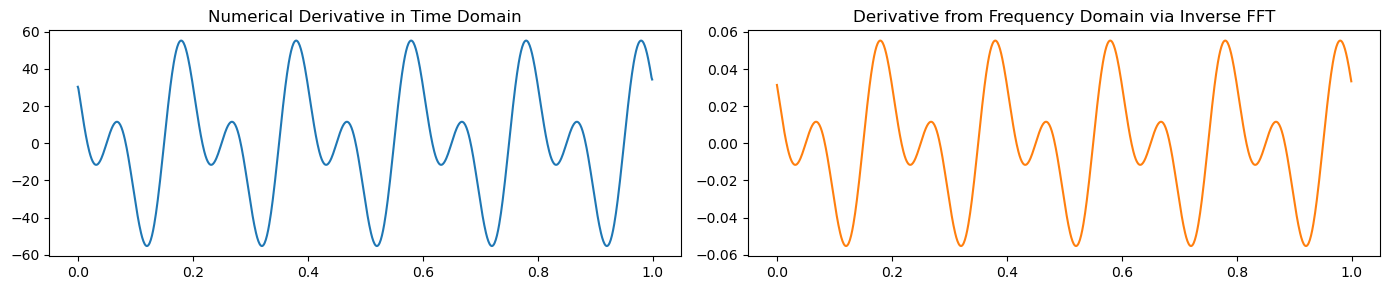

In [34]:
plot_derivative(t, dy_dt_numerical, dy_dt_from_frequency_domain)

### Integration

- The integration of a signal in the time domain corresponds to a specific transformation in the frequency domain. 
- Specifically, the Fourier transform of the integral of $f(t)$ is given by:

$$\mathcal{F}\left\{\int_{-\infty}^t f(\tau)d\tau\right\} = \frac{F(\omega)}{i\omega} + \pi F(0)\delta(\omega)$$

- where $\delta(\omega)$ is the Dirac delta function.

In [35]:
sampling_rate = 1000
T = 2.0 / sampling_rate
N = 1000
t = np.linspace(-5, 5, N)
f_t = np.sin(2 * np.pi * 5 * t) + np.cos(2 * np.pi * 3 * t) # Original signal

# Integrate f(t) in the time domain
integrated_f_t = cumulative_trapezoid(f_t, t, initial=0)

# Compute the Fourier Transform of the integrated signal
Integrated_F_w = np.fft.fft(integrated_f_t)

# Theoretical relationship 
# Compute the Fourier Transform of the original signal
F_w = np.fft.fft(f_t)
omega = 2 * np.pi * np.fft.fftfreq(t.size, T)
# Note: To avoid division by zero at omega=0, we use np.where to handle the omega=0 case separately.
# The delta function's contribution at omega=0 is theoretical and not directly applicable in discrete FFT.
Theoretical_F_w = np.where(omega != 0, F_w / (1j * omega + 1e-10), 0) # Should be equal to Integrated_F_w

In [36]:
def plot_integration(t, f_t, integrated_f_t, F_w, Integrated_F_w, Theoretical_F_w):
    plt.figure(figsize=(14, 6))

    plt.subplot(2, 2, 1)
    plt.plot(t, f_t, label='Original Signal $f(t)$')
    plt.title('Original Signal $f(t)$')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(t, integrated_f_t)
    plt.title('Integrated Signal $\int f(t) dt$')

    plt.subplot(2, 2, 3)
    plt.plot(omega, np.abs(F_w))
    plt.title('Fourier Transform of $f(t)$')
    plt.xlim(-500, 500)

    plt.subplot(2, 2, 4)
    plt.plot(omega, np.abs(Integrated_F_w), label='FT of Integrated $f(t)$', linewidth=4, alpha=0.7)
    plt.xlim(-500, 500)
    plt.legend()
    plt.twinx()
    plt.plot(omega, np.abs(Theoretical_F_w), label='Theoretical $F(\omega)/(i\omega)$', linestyle='--', color='orange')
    plt.xlim(-500, 500)
    plt.title('Fourier Transform of the Integrated Signal')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

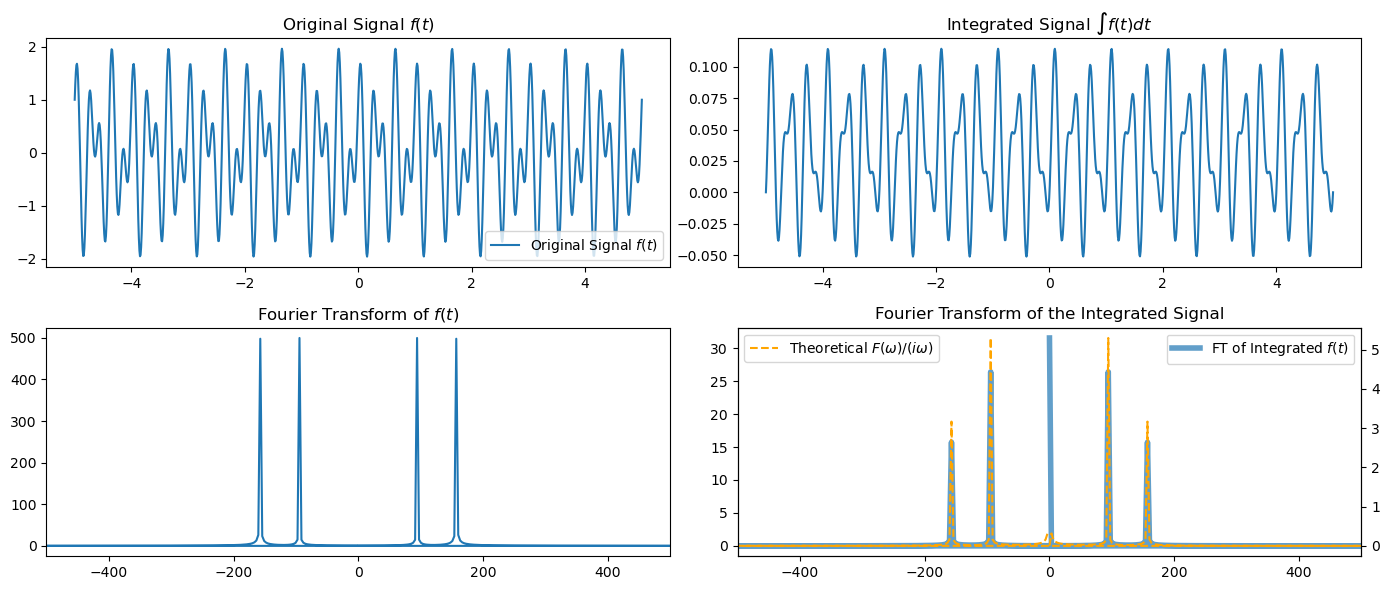

In [37]:
plot_integration(t, f_t, integrated_f_t, F_w, Integrated_F_w, Theoretical_F_w)

### Parseval's theorem

- This theorem relates the total energy of a signal in the time domain to the total energy in the frequency domain, indicating that energy is preserved in the Fourier transform. 
- Mathematically:

$$ \int_{-\infty}^{\infty} |f(t)|^2 dt = \int_{-\infty}^{\infty} |F(\omega)|^2 d\omega $$

- For discrete signals and their discrete Fourier transforms (DFTs), this can be approximated as:

$$\sum_{n=0}^{N-1} |x[n]|^2 = \frac{1}{N} \sum_{k=0}^{N-1} |X[k]|^2$$

- where $x[n]$ is the discrete time-domain signal, $X[k]$ is its DFT, and $N$ is the number of points in the signal and its DFT.
- Before, we saw that signals such as the sinusoid or the Dirac delta can be concentrated in one domain (e.g., time) and spread in the other (e.g., frequency).
- Parseval's theorem ensures that despite the localization properties, the total energy remains constant.

In [38]:
Fs = 1000  # Sampling frequency in Hz
T = 0.5  # Length of signal in seconds
t = np.arange(0, T, 1/Fs)  # Time vector

f_t = np.sin(2 * np.pi * 5 * t) + 0.5 * np.sin(2 * np.pi * 10 * t)  # Signal
F_w = np.fft.fft(f_t) # Fourier Transform

# Compute the energy in the time domain
energy_time_domain = np.sum(np.abs(f_t) ** 2)

# Compute the energy in the frequency domain
energy_freq_domain = np.sum(np.abs(F_w) ** 2) / t.size

print(f"Energy in the time domain: {energy_time_domain}")
print(f"Energy in the frequency domain: {energy_freq_domain}")

Energy in the time domain: 312.5
Energy in the frequency domain: 312.5


---

## Filters 

- In the context of signal processing and time series analysis, a filter is a tool used to modify or enhance a signal by selectively amplifying certain frequencies and attenuating others.
- A filter processes a signal to remove unwanted components or features, such as noise, or to extract useful information from the signal. 
- Filters are characterized by their **frequency response** and **transfer function**.


### Frequency response

- The frequency response of a filter characterizes the filter's output in the frequency domain. 
- It describes how the amplitude and phase of the output signal vary across different frequencies of the input signal. 
- In other words, it shows how much each frequency component of the input signal is attenuated or amplified by the filter and how the phase of these components is shifted. 
- The frequency response is typically represented as a plot of the filter's gain (or attenuation) and phase shift as functions of frequency. 
- This response is crucial for understanding how the filter will affect a signal's spectral content.

There are different categories of filters based on the frequency response.
- Low-pass filters -- allow frequencies below a certain cutoff to pass through while attenuating higher frequencies. 
- High-pass filters -- do the opposite of LPF.
- Band-pass filters -- allow frequencies within a certain range to pass through.
- Band-stop filters -- attenuate frequencies within a certain range. 

### Transfer function
- The transfer function describes how the filter modifies the amplitude and phase of components of the input signal at different frequencies. 
- To define it, we must first introduce the Laplace transform and the Z-transform.

**Laplace transform**

- The Laplace transform of a function $f(t)$, defined for $t \geq 0$, is given by 

$$F(s) = \int_{0}^{\infty} e^{-st}f(t) \,dt$$ 

- where $s = \sigma + i\omega$ is a complex number.
- The Fourier transform $F(\omega) = \int_{-\infty}^{\infty} e^{-i\omega t}f(t) \,dt$ is a special case of the Laplace transform evaluated on the imaginary axis ($s = i\omega$), where $\sigma = 0$.

- The convergence of the Fourier transform is a stricter requirement, i.e., not all functions that have a Laplace transform  have a Fourier transform. 
- While the Fourier transform is useful to analyze only the frequency content, Laplace transform is useful to analyze the overall system behavior, including stability and transient response.

**Z-transform**

- The relationship between the z-transform and the Discrete Fourier Transform (DFT) is similar to the relationship between the Laplace and Fourier transforms in the continuous domain.
- The z-transform of a discrete-time signal $x[n]$ is defined as 

$$X(z) = \sum_{n=-\infty}^{\infty} x[n]z^{-n}$$ 

- where $z$ is a complex variable ($z = re^{i\theta}$).

- The DFT $X[k] = \sum_{n=0}^{N-1} x[n]e^{-i\frac{2\pi}{N}kn}$ is a special case of z-transform evaluated on the unit circle in the complex plane, i.e., when $z = e^{i\omega}$.
- The z-transform encompasses a broader range of analysis, allowing for the examination of signals and systems inside and outside the unit circle, which is useful for stability analysis and filter design in the z-domain.

- We are now ready to introduce the *transfer function*.
- For analog filters (continuous time) it is defined as the ratio of the output signal and the input signal of the filter in the Laplace domain: 

$$H(s) = \frac{Y(s)}{X(s)}$$

- For digital filters (discrete time) the ratio is defined in the Z-domain: 

$$H(z) = \frac{Y(z)}{X(z)}$$

**Frequency response vs transfer function**

To summarize:
- The frequency response describes how the filter responds to sinusoidal inputs across a range of frequencies.
- The transfer function gives a more general mathematical model of the filter that applies to *all inputs*, not just sinusoidal inputs.
- Transfer functions are described in the Laplace or Z-domain, providing a broader analysis toolset for system properties. 
- In contrast, the frequency response is a subset of the transfer function evaluated on the imaginary axis in the Laplace domain or on the unit circle in the Z-domain.

### Bode plot

- Displays the transfer function of a system (a filter in our case).
- It displays the *amplitude* (usually in decibels, i.e., logarithmic units) of a system as a function of the frequency.
- It also displays the *phase* of a system as a function of the frequency.

- Let's create a Bode plot for a simple low-pass filter as an example. 
- The transfer function of a first-order low-pass filter can be expressed as: 

$$H(s) = \frac{\omega_c}{s + \omega_c}$$ 

- where $\omega_c$ is the cutoff frequency of the filter. 
- The cutoff frequency is the frequency at which the output signal's power is reduced to half its input power.
- In this example, let's assume a cutoff frequency $\omega_c = 1000$ rad/s. 

In [39]:
# Transfer function coefficients for H(s) = omega_c / (s + omega_c)
omega_c = 1000  # Cutoff frequency in rad/s
num = [omega_c]  # Numerator coefficients
den = [1, omega_c]  # Denominator coefficients

w, H = signal.freqs(num, den, worN=np.logspace(1, 5, 512)) # Compute frequency response
mag = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

In [40]:
def make_bode_plot(w, mag, phase, omega_c=None, omega_signal=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 3))

    ax1.semilogx(w, mag)  # Bode magnitude plot
    ax1.set_ylabel('Magnitude (dB)')
    ax1.set_xlabel('Frequency (rad/s)')
    ax1.grid(which='both', axis='both')
    if omega_c != None:
        if type(omega_c) is list:
            for o in omega_c:
                ax1.axvline(o, color='red', linestyle='--') # Cutoff frequency
        else:
            ax1.axvline(omega_c, color='red', linestyle='--') # Cutoff frequency
            
    if omega_signal != None:
        ax1.axvline(omega_signal, color='tab:green', linestyle='--')

    ax2.semilogx(w, phase)  # Bode phase plot
    ax2.set_ylabel('Phase (degrees)')
    ax2.set_xlabel('Frequency (rad/s)')
    ax2.grid(which='both', axis='both')

    plt.tight_layout()
    plt.show()

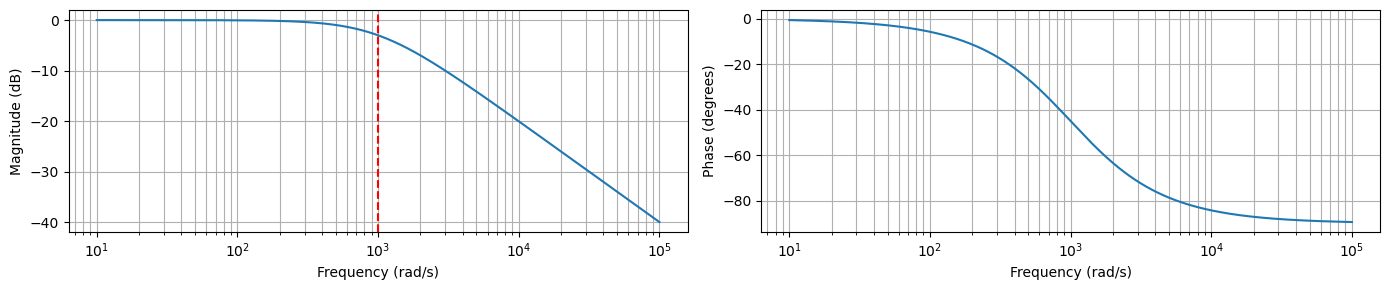

In [41]:
make_bode_plot(w, mag, phase, omega_c) 

**Magnitude plot (left)**
- Shows how the filter attenuates signals at different frequencies. 
- Frequencies lower than the cutoff frequency ($\omega_c = 1000$ rad/s) are passed with little attenuation.
- Frequencies higher than the cutoff frequency are increasingly attenuated. 

**Phase plot (right)**
- Illustrates the phase shift introduced by the filter across different frequencies. 
- For a low-pass filter, the phase shift goes from 0 degrees at low frequencies to -90 degrees at high frequencies. 
- The transition occurs smoothly across the frequency range, with a noticeable change around the cutoff frequency.

---

## Low pass filters (LPFs)

- As we mentioned earlier, a LPF passes signals with a frequency lower than a certain cutoff frequency.
- LPFs provide a smoother signal, removing fast fluctuations.
- LPFs are commonly used to get rid of the high-frequency components of the noise.
- Moving averages are a type of LPFs.
- Other representative of LPFs include the Hann Window, the Tukey Filter, and the Butterworth Filter.  

### Hann window

- The Hann window, named after Julius von Hann, is sometimes referred to as "Hanning" or as "raised cosine".  
- The shape of the filter in time domain is one lobe of an elevated cosine function. 
- On the interval $n\in [0,N-1]$ the Hann window function is:

$$w(n)=0.5\;\left[1-\cos \left({\frac {2\pi n}{N-1}}\right)\right]=\sin ^{2}\left({\frac {\pi n}{N-1}}\right)$$

- Let's generate a Hann window of size $51$. 
- Then, we plot the window and compute its frequency response with the function we have defined before.

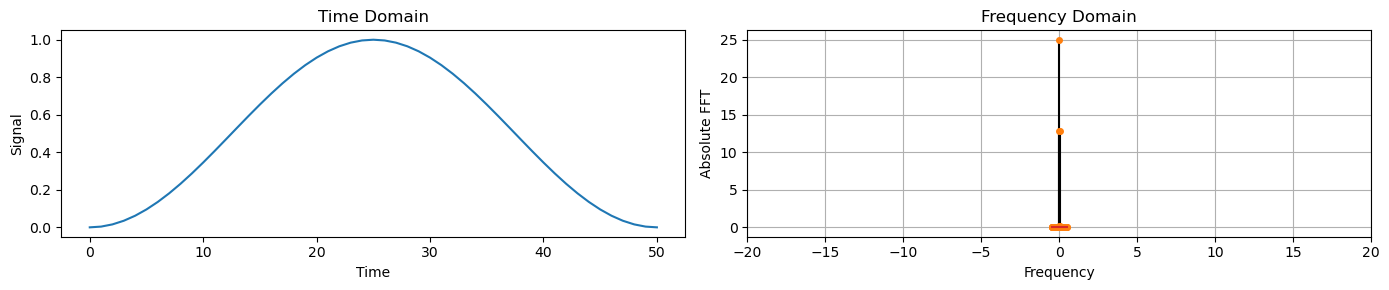

In [42]:
window = signal.windows.hann(51)

plot_time_freq(np.arange(len(window)), window)

- Unfortuantely we do not see much in the frequency domain since the response is compressed in a very short interval.
- To visualize these kind of signals we must apply some transformations that allows us to "zoom in" and see the details.

In [43]:
def plot_hann():
    window = signal.windows.hann(51)

    plt.figure(figsize = [10,3])
    plt.subplot(1,2,1)
    plt.plot(window)
    plt.title("Hann window")
    plt.ylabel("Amplitude")
    plt.xlabel("Sample")

    plt.subplot(1,2,2)
    A = np.fft.fft(window, 2048) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = np.abs(np.fft.fftshift(A / abs(A).max()))
    response = 20 * np.log10(np.maximum(response, 1e-10))
    plt.plot(freq, response, color='tab:orange')
    plt.axis([-0.5, 0.5, -120, 0])
    plt.title("Frequency response of the Hann window")
    plt.ylabel("Normalized magnitude [dB]")
    plt.xlabel("Normalized frequency [cycles per sample]")
    plt.grid()

    plt.tight_layout()
    plt.show()

- This is a typical visualization of the window that we generated before.

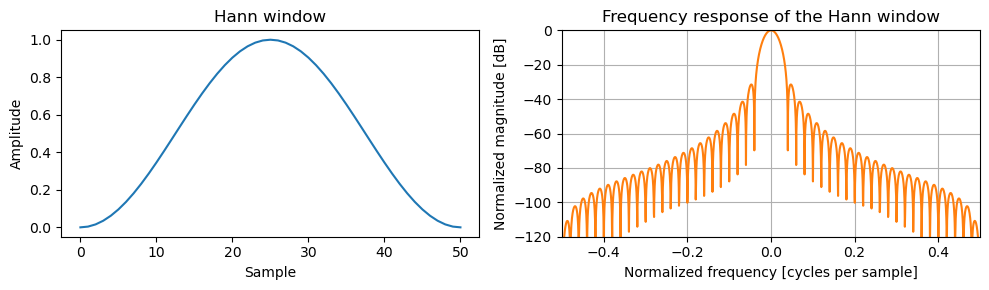

In [44]:
plot_hann()

### Tukey filter

- The Tukey filter is also known as the Tukey window or "tapered cosine window".
- It can be regarded as a cosine lobe of width $\alpha N/2$ that is convolved with a rectangular window of width $(1 − α/2)N$.  
- The expression of the filter in time domain is given by:

$$ w(n)={\begin{cases}{\frac{1}{2}}\left[1+\cos \left(\pi \left({\frac {2n}{\alpha (N-1)}}-1\right)\right)\right]&0\leqslant n<{\frac {\alpha (N-1)}{2}}\\1&{\frac {\alpha (N-1)}{2}}\leqslant n\leqslant (N-1)(1-{\frac {\alpha }{2}})\\{\frac {1}{2}}\left[1+\cos \left(\pi \left({\frac {2n}{\alpha (N-1)}}-{\frac {2}{\alpha }}+1\right)\right)\right]&(N-1)(1-{\frac {\alpha }{2}})<n\leqslant (N-1)\end{cases}}$$

In [45]:
def plot_tukey(alpha):
    window = signal.windows.tukey(51, alpha=alpha)

    plt.figure(figsize = [10,3])
    plt.subplot(1,2,1)
    plt.plot(window)
    plt.title("Tukey window")
    plt.ylabel("Amplitude")
    plt.xlabel("Sample")

    plt.subplot(1,2,2)
    A = np.fft.fft(window, 2048) / (len(window)/2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(np.fft.fftshift(A / abs(A).max())))
    plt.plot(freq, response, color='tab:orange')
    plt.axis([-0.5, 0.5, -120, 0])
    plt.title("Frequency response of the Tukey window")
    plt.ylabel("Normalized magnitude [dB]")
    plt.xlabel("Normalized frequency [cycles per sample]")
    plt.grid()

    plt.tight_layout()
    plt.show()

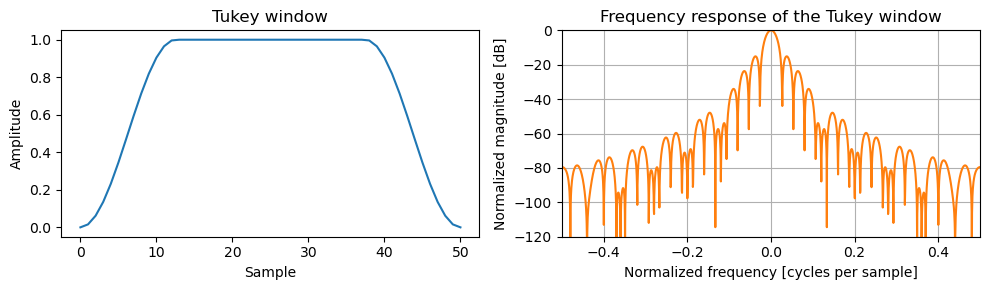

In [46]:
plot_tukey(0.5)

- When $\alpha \rightarrow 0$ the Tukey converges to a rectangular window.

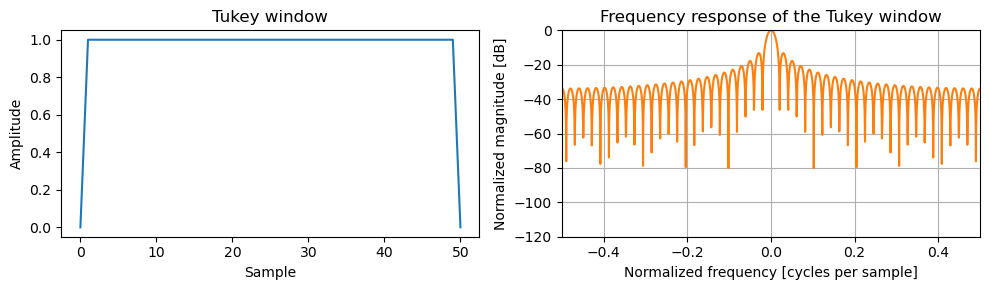

In [47]:
plot_tukey(1e-10)

- At $\alpha = 1$ the Tukey filter becomes a Hann window.

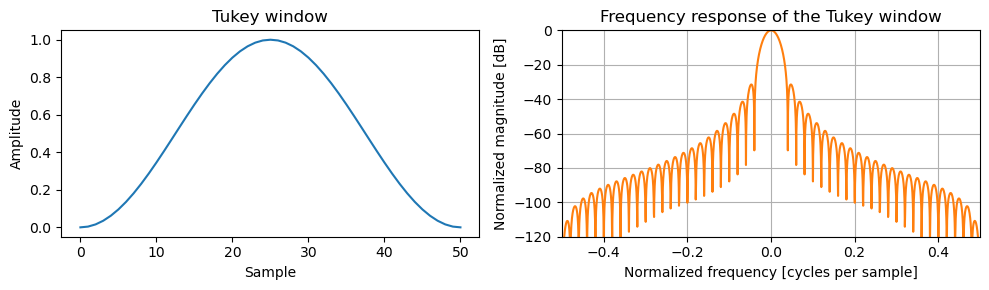

In [48]:
plot_tukey(1)

- In both Hann and Tukey windows, in the frequency domain the shape of the filter becomes close to zero at high frequencies.  

- Next, we apply the filter to a noisy signal.
- We do that by mutiplying the signal and the filter in the frequency domain.
- The output should show a reduction in the high frequency components.
- With the inverse FFT we map the output back in the time domain.

In [49]:
# Let's create a function to show the results.
def filter_plot(time, y_noisy, y_clean, y_filtered, legend_names, alpha=1):
    plt.figure(figsize=[9,3])
    plt.plot(time, y_noisy, 'k', lw=1)
    plt.plot(time, y_clean, 'tab:blue', lw=3)
    plt.plot(time, np.real(y_filtered), 'tab:red', linestyle='--', lw=3, alpha=alpha)
    plt.legend(legend_names);

In [50]:
time = np.linspace(0, 5, 512)
freq = 1.5
y_sine = np.sin(2 * np.pi * freq * time)
y_trend = (0.2 * time)**2
y_noise = 0.5 * np.random.randn(len(time))
noisy_signal = y_sine + y_trend + y_noise

Window length: 32


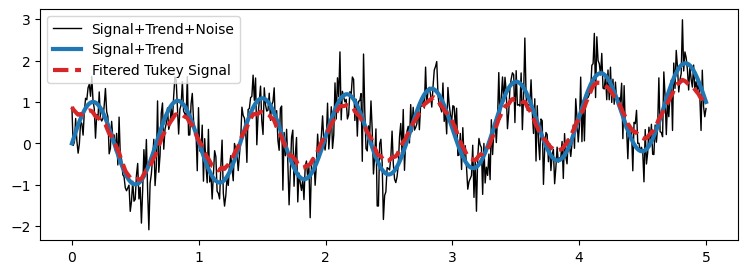

In [51]:
alpha=0.1 # Filter's parameters
div_factor = 16 # use powers of 2
win_len = int(len(time) / div_factor)
print(f"Window length: {win_len}")

# Compute window
window = signal.windows.tukey(win_len, alpha=alpha)

# Compute frequency response
response = np.fft.fft(window, len(time))
response = np.abs(response / abs(response).max())

# Apply filter
Y = (np.fft.fft(noisy_signal))
y_tukey = np.fft.ifft(Y*response)

filter_plot(time, noisy_signal, y_sine+y_trend, y_tukey, ['Signal+Trend+Noise','Signal+Trend','Fitered Tukey Signal'])

- We can observe that the "Filtered Signal" matches very closely the "Signal + Trend" because most of the noise has been removed.  

### Butterworth filter

- The Butterworth filter is designed to have a frequency response as flat as possible in the *passband*.
- The passband is the part of the filter that allows certain frequencies (left of the green line in the figure below).
- Conversely, the *stopband* is the parts of the filter that rejects/dampens the frequency (right of the green line).
- The Butterworth filter avoids ripples both in the passband and in the stopband, providing a smooth transition between these regions.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/6/60/Butterworth_response.svg/640px-Butterworth_response.svg.png" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Image: <a href="https://commons.wikimedia.org/wiki/File:Butterworth_response.svg">Wikimedia</a></div>

- Contrarily to the two window-based filters that we have just seen, the Butterworth filter is defined directly in the frequency domain.
- As such, it does not have a proper "shape" that we can visualize in the time domain.
- Therefore, we will use the Bode plot, which is the tool for visualizing a frequency response.

The magnitude of the frequency response of an $N$-th order Butterworth LPF is:

$$|H(\omega)| = \frac{1}{\sqrt{1 + \left(\frac{\omega}{\omega_c}\right)^{2N}}}$$

where:
- $\omega$ is the frequency of the input signal.
- $\omega_c$ is the cutoff frequency, i.e., where the magnitude response is $\frac{1}{\sqrt{2}}$ (or -3 dB) of the passband value.
- $N$ is the order of the filter; it determines the steepness of the filter's roll-off beyond the cutoff frequency. The higher $N$, the steeper the roll-off.

In summary:
- Frequencies much lower than $\omega_c$ pass through with little attenuation. 
- Frequencies much higher than $\omega_c$ are significantly attenuated. 
- The transition between the passband and the stopband is smooth.
- The steepness of this transition increasing with the filter order $N$.

- Let's consider a signal given by the sum of two sinusoids.
- The first sinusoid $y_1$ has a frequency $f_1 = 10$ Hz.
- The second sinusoid $y_2$ has a frequency $f_2 = 15$ Hz.

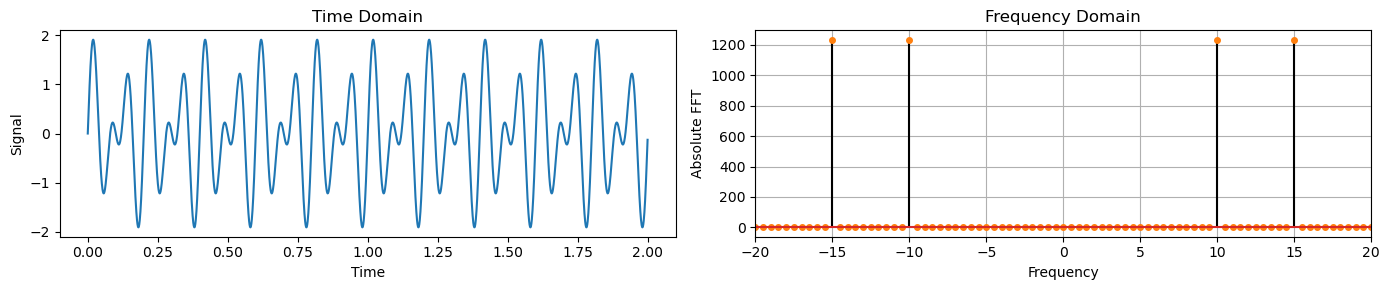

In [52]:
Fs = 1234     # Sampling frequency in Hz
duration = 2  # seconds
t = np.arange(0, duration, 1/Fs)  # Time vector

freq1, freq2 = 10, 15

y1 = np.sin(2 * np.pi * freq1 * t)
y2 = np.sin(2 * np.pi * freq2 * t)
y_12 = y1 + y2
plot_time_freq(t, y_12)

- We want to design a low-pass filter to remove $y_2$, the $15$ Hz component, from the signal.
- We can use a LPF with cut frequency $f_c = 12$ Hz.
- Before, we applied the filter by multiplying the FFT of the filter and the signal and then computed the inverse.
- This time, we use the `filtfilt` function, which directly applies a digital filter to a signal.

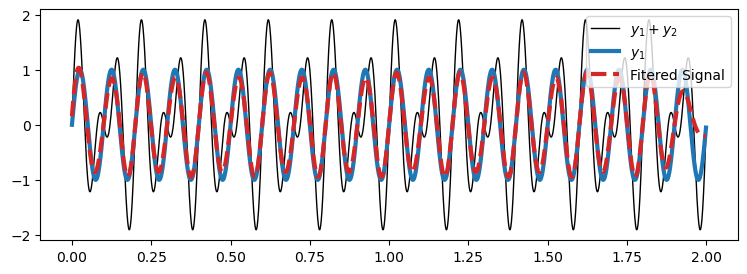

In [53]:
freq_c = 12

 # Numerator (B) and denominator (A) polynomials of the filter
B, A = signal.butter(N=6, Wn=freq_c, btype='lowpass', analog=False, fs=1234) 
 
# Apply the filter
y_low_butter = signal.filtfilt(B, A, y_12)

# plot
filter_plot(t, y_12, y1, y_low_butter, 
            ['$y_1 + y_2$','$y_1$','Fitered Signal'])

- We see that the the $10$ Hz component, $y_1$, is recovered in the filtered signal.

- Next, we want to remove the noise from the noisy signal we defined before (sinusoid + trend + noise).
- Before, we specified the cutoff frequency $f_c$ in Hertz.
- We can equivalently express the cutoff as an angular frequency $\omega_c$.
- Based on the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html):
> "For digital filters, if `fs` is not specified, `Wn` units are normalized from 0 to 1, where 1 is the Nyquist frequency (`Wn` is thus in half cycles / sample and defined as 2\* *critical frequencies* / *fs*)."

- Before, we defined a sinusoid with frequency `1.5`.
- Let's compute the angular frequency $\omega$ that corresponds to this frequency.

In [54]:
freq = 1.5 # Frequency in Hz of the sinusoid
time = np.linspace(0, 5, 512) # Time vector

# Compute the sampling resolution
fs = 1/(time[1]-time[0])

# Compute the Nyquist frequency
nyq = 0.5 * fs

# Compute the angular frequency
omega = freq / nyq
print(f" ω = {omega:.3f}")

 ω = 0.029


- To allow the sinusoid frequency $\omega=0.029$ and cut the higher ones, we can set $\omega_c = 0.05$.

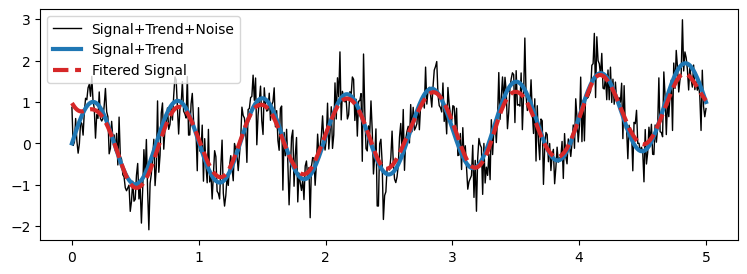

In [55]:
omega_c = 0.05
B, A = signal.butter(N=2, Wn=omega_c, btype='lowpass')
 
# Apply the filter
y_low_butter = signal.filtfilt(B, A, noisy_signal)

# plot
filter_plot(time, noisy_signal, y_sine+y_trend, y_low_butter, 
            ['Signal+Trend+Noise','Signal+Trend','Fitered Signal'])

- Once again the filtered signal resembles the original signal without the noise. 

- Finally, we compute the Bode plot to see the shape of the LPF.
- In green, we plot $\omega$ the frequency of the signal.
- In red, we plot $\omega_c$ the cutoff frequency of the filter.

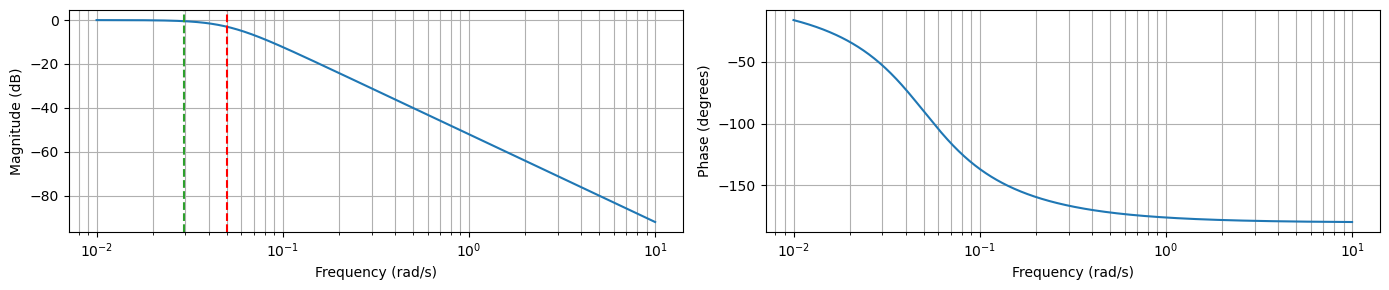

In [56]:
B, A = signal.butter(N=2, Wn=omega_c, btype='lowpass', analog=True) # For the plot, we need the analog response
w, H = signal.freqs(B, A, worN=np.logspace(-2, 1, 512)) # Compute frequency response
magnitude = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

make_bode_plot(w, magnitude, phase, omega_c, omega)

---

## High pass filters (HPFs)

Allows signals with frequencies higher than a certain cutoff frequency to pass through, while attenuating (reducing) signals with frequencies below the cutoff.

<img src="https://upload.wikimedia.org/wikipedia/commons/4/4d/75_Hz_HPF_on_Smaart.jpg" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Image: <a href="https://upload.wikimedia.org/wikipedia/commons/4/4d/75_Hz_HPF_on_Smaart.jpg">Wikimedia</a></div>

- LPFs are used to smooth out signals, remove noise, and preserve the basic shape of the signal without the details provided by high-frequency components.
- Conversely, HPFs are often used to enhance or isolate quick changes in signals (e.g., edges in images or high-frequency sounds in audio).
- One application of HPFs is to filter out low frequency components and get rid of the trend. 

Let's use a Butterworth filter in a high pass filter configuration.

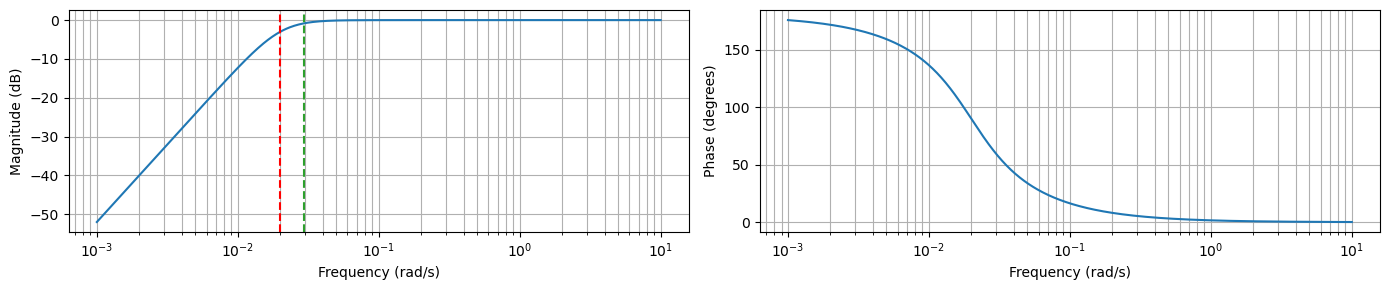

In [57]:
# High Pass Butterworth filter
N  = 2    # Filter order
omega_c = 0.02 # Cutoff frequency
B, A = signal.butter(N, omega_c, btype='highpass', output='ba', analog=True) 

w, H = signal.freqs(B, A, worN=np.logspace(-3, 1, 512)) # Compute frequency response
magnitude = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

make_bode_plot(w, magnitude, phase, omega_c, omega)

- The magnitude plot is flipped left-to-right.
- The phase plot is shifted upwards, but the shape is unchanged.

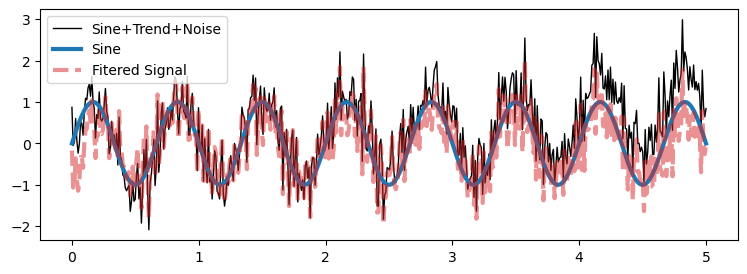

In [58]:
B, A = signal.butter(N, omega_c, btype = 'highpass', output='ba') 
 
# Apply the filter
y_high_butter = signal.filtfilt(B, A, noisy_signal)

# plot
filter_plot(time, noisy_signal, y_sine, y_high_butter, 
            ['Sine+Trend+Noise','Sine','Fitered Signal'], alpha=0.5)

- We can observe that the trend has been removed.

---

## Band pass filters

- A band pass filter (BPF) passes frequencies within a certain range and rejects frequencies outside that range.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Band-pass_filter.svg/640px-Band-pass_filter.svg.png" style="width: 40%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Image: <a href="https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Band-pass_filter.svg/640px-Band-pass_filter.svg.png">Wikimedia</a></div>

- A BPF can be seen as a combination of a high pass and low pass filters that remove both the high and low frequency components of a signal. 

<img src="media/filter.png" style="width: 65%; display: block; margin: auto;">

- In particular, we can implement a BPF using a LPF and HPF Butterworth filters.

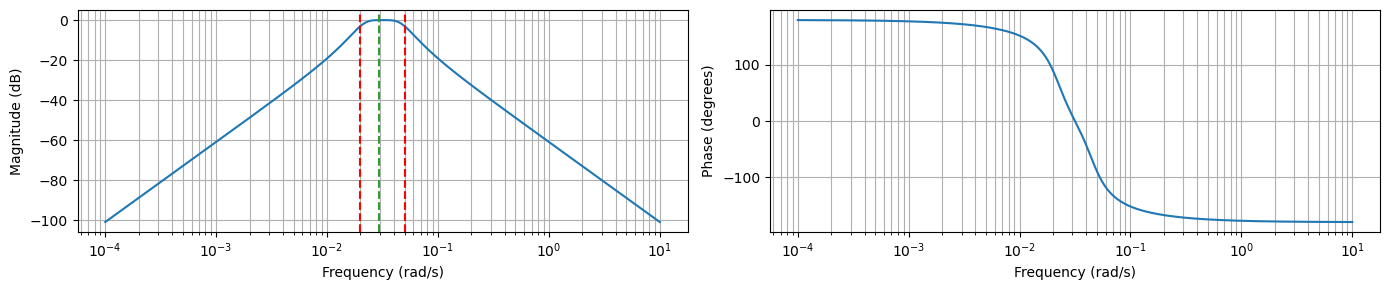

In [59]:
# Band Pass Butterworth filter
N  = 2    # Filter order
omega_c = [0.02, 0.05] # Cutoff frequencies
B, A = signal.butter(N, omega_c, btype = 'bandpass', output='ba', analog=True) 

w, H = signal.freqs(B, A, worN=np.logspace(-4, 1, 512)) # Compute frequency response
magnitude = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

make_bode_plot(w, magnitude, phase, omega_c, omega)

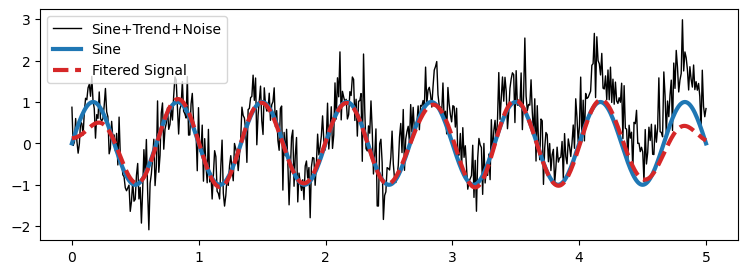

In [60]:
B, A = signal.butter(N, omega_c, btype = 'bandpass', output='ba') 
 
# Apply the filter
y_band_butter = signal.filtfilt(B, A, noisy_signal)

# plot
filter_plot(time, noisy_signal, y_sine, y_band_butter, 
            ['Sine+Trend+Noise','Sine','Fitered Signal'])

We observe that the original signal has been de-trended, and the noise has been removed.   

---

## Band-stop filters

- A band-stop filter (BSF) passes most frequencies unaltered, but attenuates those in a specific range to very low levels.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Ideal_Band_Stop_Filter_Transfer_Function.svg/640px-Ideal_Band_Stop_Filter_Transfer_Function.svg.png" style="width: 30%; display: block; margin: auto;">

<div style="text-align: center; font-size: 80%;">Image: <a href="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8b/Ideal_Band_Stop_Filter_Transfer_Function.svg/640px-Ideal_Band_Stop_Filter_Transfer_Function.svg.png">Wikimedia</a></div>

- For the next example, we generate a new signal that is the sum of 3 sinusoids.
- Then, we design a filter to remove the 3rd sinusoid.

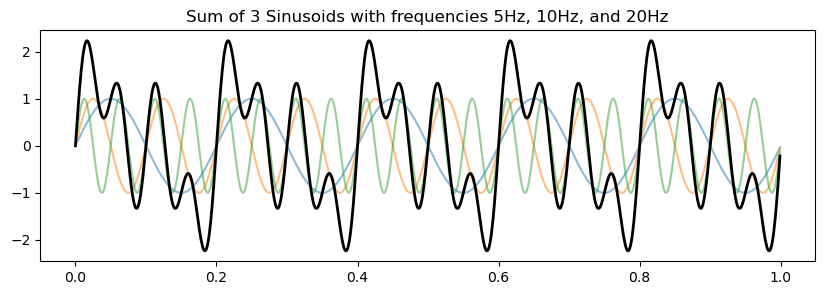

In [61]:
fs = 1000  # Sampling frequency in Hz
f1, f2, f3 = 5, 10, 20  # Frequencies of the three sinusoids in Hz
duration = 1  # seconds
t = np.arange(0, duration, 1/fs)  # Time vector

sinusoid1 = np.sin(2 * np.pi * f1 * t)
sinusoid2 = np.sin(2 * np.pi * f2 * t)
sinusoid3 = np.sin(2 * np.pi * f3 * t)

Y = sinusoid1 + sinusoid2 + sinusoid3 # Combined signal

plt.figure(figsize=(10, 3))
plt.plot(t, sinusoid1, alpha=0.5)
plt.plot(t, sinusoid2, alpha=0.5)
plt.plot(t, sinusoid3, alpha=0.5)
plt.plot(t, Y, 'k', linewidth=2)
plt.title(f'Sum of 3 Sinusoids with frequencies {f1}Hz, {f2}Hz, and {f3}Hz');

In [62]:
# Filter parameters to reject the third sinusoid
lowcut = f3 - 5  # Just below the third frequency
highcut = f3 + 5  # Just above the third frequency

# Scale the values by the sampling frequency
nyq = 0.5 * fs
omega_c_low = lowcut / nyq
omega_c_high = highcut / nyq
omega = f3 / nyq

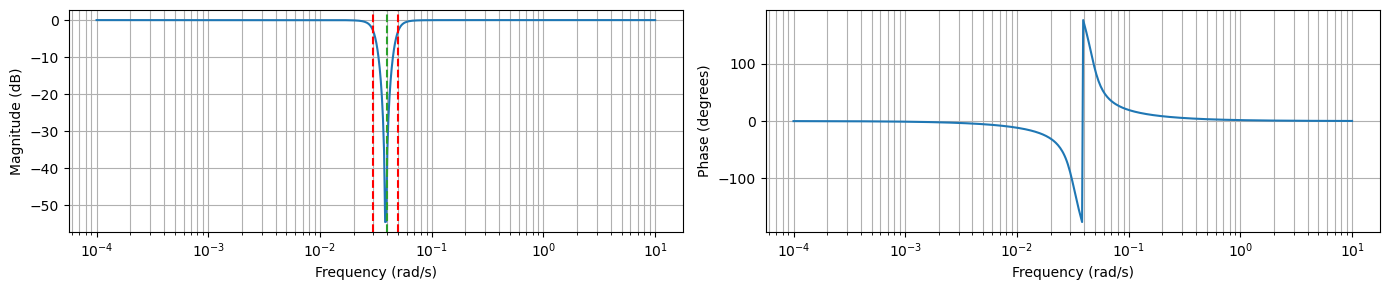

In [63]:
# Band Stop Butterworth filter
N  = 2    # Filter order
omega_c = [omega_c_low, omega_c_high] # Cutoff frequencies
B, A = signal.butter(N, omega_c, btype = 'bandstop', output='ba', analog=True) 

w, H = signal.freqs(B, A, worN=np.logspace(-4, 1, 512)) # Compute frequency response
magnitude = 20 * np.log10(abs(H))  # Convert magnitude to dB
phase = np.angle(H, deg=True)  # Phase in degrees

make_bode_plot(w, magnitude, phase, omega_c, omega)

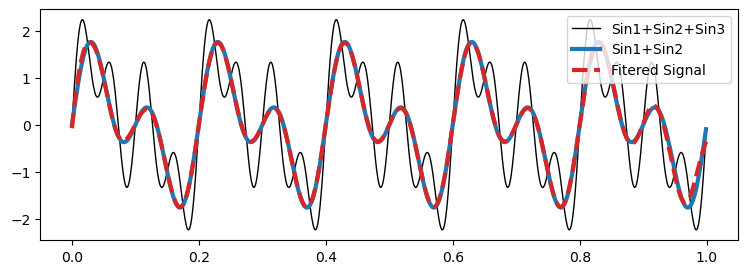

In [64]:
B, A = signal.butter(N, omega_c, btype = 'bandstop', output='ba') 
 
# Apply the filter
y_stop_butter = signal.filtfilt(B, A, Y)

# plot
filter_plot(t, Y, sinusoid1+sinusoid2, y_stop_butter, 
            ['Sin1+Sin2+Sin3','Sin1+Sin2','Fitered Signal'])

- The effect of the third sinusoid has been completely removed from the signal.
- An application of this filter is to remove a specific seasonality from the data.

---

## Making forecasts with Fourier transforms

- We will forecast future values of a time series based on its past observations using Fourier analysis. 
- We will achieve this by decomposing the time series into its frequency components, eliminating the trend, and then reconstructing the signal to predict future values.

- We will define a function `fourierPrediction(y, n_predict, n_harm)` for this purpose.
- The function returns `n_predict` future points of the original time series (with the linear trend) reconstructed using the specified number of harmonics `n_harm`.

Let's break down the steps implemented by the function.

1. **Define the number of harmonics** 

    - Harmonics are sine and cosine functions with frequencies that are integer multiples of a fundamental frequency.
    - The input parameter `n_harm` specifies the number of harmonics used in the Fourier series expansion. 
    - By using multiple harmonics, the model can approximate the original time series more accurately.
    - Using too many harmonics might overfit the data as they will start to model the noise.

2. **Trend removal** 

    - The function first computes a linear trend of the time series `y` using `np.polyfit(t, y, 1)`, which fits a first-degree polynomial to the data, i.e., a straight line with form $\beta_1 t + \beta_0$, where $\beta_1$ is the slope (stored in `p[0]`) and $\beta_0$ is intercept (stored in `p[1]`).
    - This trend is then subtracted from the original time series to obtain a detrended series `y_notrend`. 
    - Detrending is crucial for letting the Fourier analysis focus on the cyclical components of the time series without the influence of the underlying trend.

3. **Fourier transform** 

    - The detrended time series is transformed into the frequency domain using the Fast Fourier Transform (FFT) with `np.fft.fft(y_notrend)`. 
    - The FFT algorithm computes the Discrete Fourier Transform (DFT), which represents the original time series as a sum of cosine and sine waves with different frequencies and amplitudes.

4. **Frequency identification** 

    - The `np.fft.fftfreq(n)` function generates an array of frequencies associated with the components of the FFT. 
    - These frequencies are needed for reconstructing the signal later.

5. **Sorting indexes by largest frequency components** 

    - The indexes of the frequency components are sorted according to their magnitude. 
    - In this way, the most important frequency components of the signal (i.e., those that contribute the most to its shape) will come first.

6. **Signal reconstruction and prediction** 

    - The function reconstructs the time series (and extends it to predict future values) by summing the first `1 + n_harm * 2` sorted harmonic components. 
    - The `* 2` is there because each harmonic has a positive and a negative frequency component in the FFT output.
    - Each harmoic is defined by the amplitude (`amp`), frequency (`f[i]`), and phase (`phase`) given by the FFT. 
    - The reconstructed signal at each time point `t` is the sum of these harmonics, each represented by `amp * np.cos(2 * np.pi * f[i] * t + phase)`. 

7. **Adding back the trend** 

    - Finally, the linear trend previously removed is added back to the reconstructed signal. 

In [65]:
def fourierPrediction(y, n_predict, n_harm = 5):
    n = y.size                         # length of the time series
    t = np.arange(0, n)                # time vector
    p = np.polyfit(t, y, 1)            # find linear trend in x
    y_notrend = y - p[0] * t - p[1]    # detrended x
    y_freqdom = np.fft.fft(y_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    
    # Sort indexes by largest frequency components
    indexes = np.argsort(np.absolute(y_freqdom))[::-1]

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        amp = np.absolute(y_freqdom[i]) / n   # amplitude
        phase = np.angle(y_freqdom[i])        # phase
        restored_sig += amp * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t + p[1] # add back the trend

In [66]:
def fourierPredictionPlot(y, prediction):
    plt.figure(figsize=(10, 3))
    plt.plot(np.arange(0, y.size), y, 'k', label = 'data', linewidth = 2, alpha=0.5)
    plt.plot(np.arange(0, prediction.size), prediction, 'tab:red', label = 'prediction')
    plt.grid()
    plt.legend()
    plt.show()

### Forecast example 1

- Here, we will consider the prediction of the noisy sinusoid with trend.

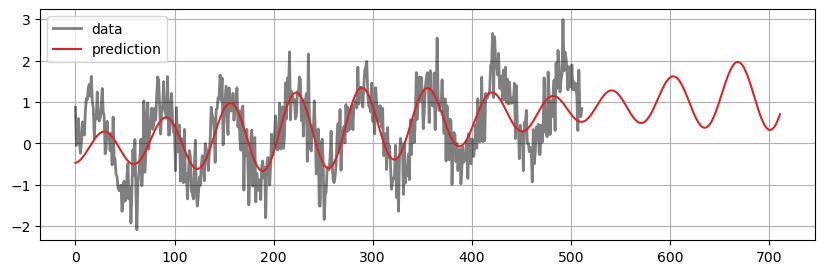

In [67]:
prediction = fourierPrediction(noisy_signal, n_predict=200, n_harm=1)

fourierPredictionPlot(noisy_signal, prediction)

### Forecast example 2

- Here, we try to predict the CO2 Data.

In [68]:
co2 = sm.datasets.get_rdataset("co2", "datasets").data
print(co2.head())

# Convert decimal year to pandas datetime
def convert_decimal_year_to_datetime(decimal_years):
    dates = [(pd.to_datetime(f'{int(year)}-01-01') + pd.to_timedelta((year - int(year)) * 365.25, unit='D')).date() 
             for year in decimal_years]
    return dates
co2['time'] = convert_decimal_year_to_datetime(co2['time'])

# Convert the column ds to datetime
co2['time'] = pd.to_datetime(co2['time'])
print("\nConverted:\n------------------\n", co2.head())

# Resample to monthly frequency based on the ds column
co2 = co2.resample('MS', on='time').mean().reset_index()

# Replace NaN with the mean of the previous and next value
co2['value'] = co2['value'].interpolate()
print("\nResampled:\n------------------\n", co2.head())

          time   value
0  1959.000000  315.42
1  1959.083333  316.31
2  1959.166667  316.50
3  1959.250000  317.56
4  1959.333333  318.13

Converted:
------------------
         time   value
0 1959-01-01  315.42
1 1959-01-31  316.31
2 1959-03-02  316.50
3 1959-04-02  317.56
4 1959-05-02  318.13

Resampled:
------------------
         time     value
0 1959-01-01  315.8650
1 1959-02-01  316.1825
2 1959-03-01  316.5000
3 1959-04-01  317.5600
4 1959-05-01  318.1300


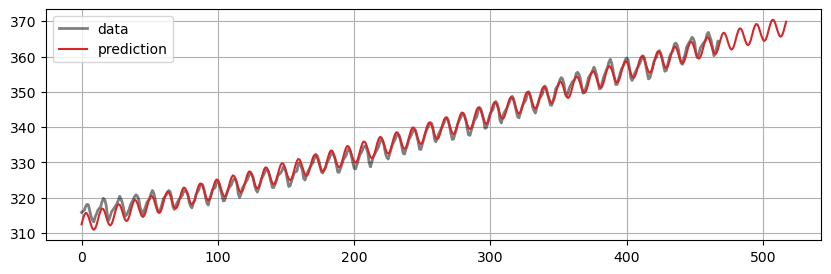

In [69]:
prediction = fourierPrediction(co2['value'], n_predict=50, n_harm=1)

fourierPredictionPlot(co2['value'], prediction)

### Detrending example

- The forecasting approach based on FT can also be used to remove trend and seasonality.
- In the following, we repeat the same example from Lecture 4: forecasting with an AR model.

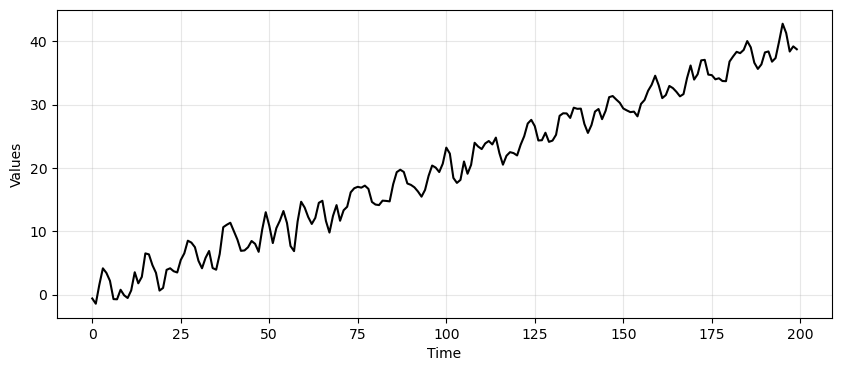

In [70]:
# Generate data from an AR(2) process
ar_data = arma_generate_sample(ar=np.array([1.0, -0.5, 0.7]), ma=np.array([1]), nsample=200, scale=1, burnin=1000)

# Add trend and seasonality
time = np.arange(200)
trend = time * 0.2
seasonality = 2*np.sin(2*np.pi*time/12)
time_series_ar = trend + seasonality + ar_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ar, "", ax=ax);

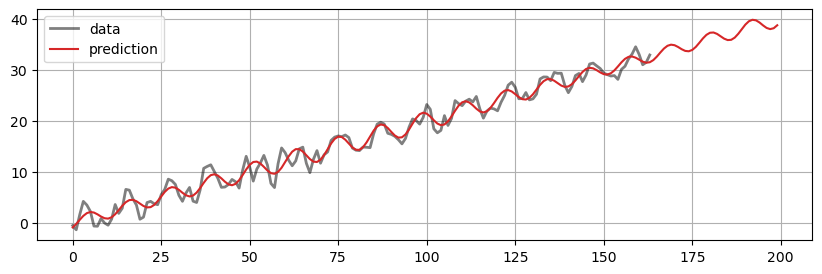

In [71]:
# Train/test split
train_data_ar = time_series_ar[:164]
test_data_ar = time_series_ar[164:]

prediction = fourierPrediction(train_data_ar, n_predict=len(test_data_ar), n_harm=1)

fourierPredictionPlot(train_data_ar, prediction)

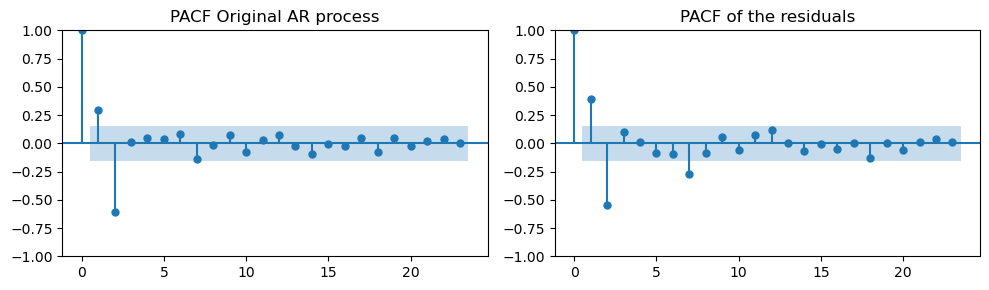

In [72]:
# Estimate trend and seasonality and remove them
trend_and_seasonality = prediction[:len(train_data_ar)]
resid = train_data_ar - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_pacf(ar_data[:len(train_data_ar)], ax=axes[0], title="PACF Original AR process")
plot_pacf(resid, ax=axes[1], title="PACF of the residuals")
plt.tight_layout();

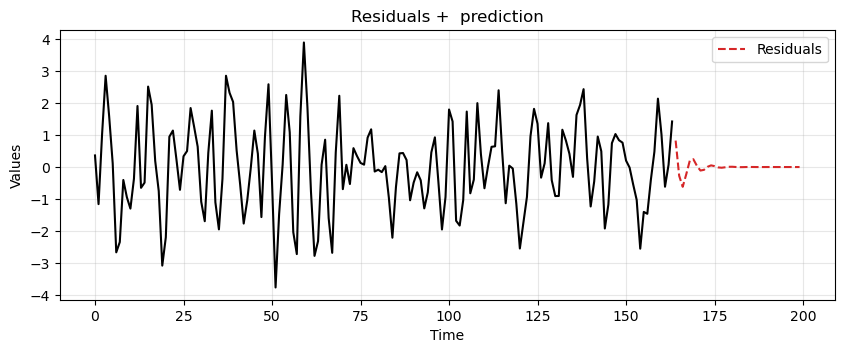

In [73]:
# Fit the model
model = ARIMA(resid, order=(2,0,0))
model_fit = model.fit()

# Compute predictions
resid_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[:len(train_data_ar)], resid, "")
ax.plot(time[len(train_data_ar):], resid_preds, label='Residuals', linestyle='--', color='tab:red')
plt.title('Residuals +  prediction')
plt.legend();

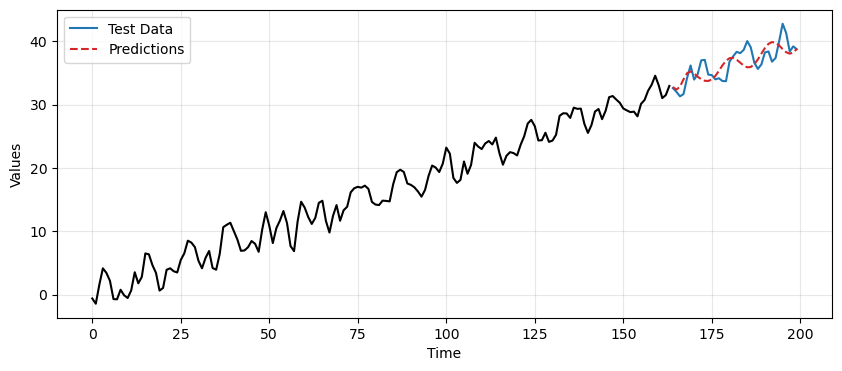

In [74]:
# Add back trend and seasonality to the predictions
ft_preds = prediction[len(train_data_ar):]
final_preds = ft_preds + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

---

## Summary

In this lecture we learned some basic concepts from signal processing. In particular

- A basic understanding of the Fourier Transform and the Discrete Fourier Transform.
- A practical knowledge of how to apply the Fast Fourier Transform.
- The FT of common signals and the main properties of the FT.
- The concepts of frequency response and transfer function
- Different types of filters, their properties, and the Bode diagram.
- How to use FT in forecasting tasks.

---

## Exercises

### Exercise 1

- Combine (add) the [sine, trend, and noise](#signal-with-trend-and-noise) we defined earlier and obtain a singal composed of:
    * A sine wave representing seasonality.
    * a parabolic function representing a trend.
    * and uniformly distributed random noise.
- Plot the time and frequency domain components.
- Modify the amplitude of the sine, trend, and noise components so that each component, in turn, dominates over the others. Comment on how the FT of the total signal changes.
- Modify the sine into a signal that is the sum of 2 sine waves of different amplitudes at 1 and 10 Hz as well as a constant term.  Make a plot in both time and frequency domains and comment the results.

### Exercise 2

- Consider the following noisy signal:

In [75]:
time = np.linspace(0, 5, 512)
y_sine = 2*np.sin(2 * np.pi * 0.5 * time)
y_cos = 1.5*np.cos(2 * np.pi * 2.5 * time)
y_trend = (0.5 * time)**2
y_noise = 0.8 * np.random.randn(len(time))
y_signal = y_sine + y_cos + y_trend
noisy_signal = y_signal + y_noise

- Apply the [Tukey filter](#tukey-filter) to the `noisy_signal`.
- Modify the values `alpha` and `div_factor` of the filter to recover the clean signal `y_signal`.

### Exercise 3

- Consider the `noisy_signal` from [Exercise 2](#exercise-2) .
- Now, your task is to recover `y_signal` using the [low-pass Butterworth filter](#butterworth-filter).
- Modify the filter order $N$ and cutoff frequency $\omega_c$ of the Butterworth filter.
- Which values seem to be the best in getting rid of the noise?

### Exercise 4

- Consider the `noisy_signal` from [Exercise 2](#exercise-2).
- Now, your task is to recover `y_signal` and then remove its trend component (`y_trend`).
- To do that, you will first apply the [high-pass Butterworth filter](#high-pass-filters-hpfs).
- Optimize, by hand, the filter order $N$ and cutoff frequency $\omega_c$ of the Butterworth filter.
- Then, apply the LPF in cascade to the HPF. 
- The result should contain neither trend nor noise.

### Exercise 5

- Consider the `noisy_signal` from [Exercise 2](#exercise-2).
- Once again, your task is to recover `y_signal` and then remove its trend component (`y_trend`).
- Optimize, by hand, the filter order $N$ and the cutoff frequencies $\omega_c^\text{LOW}$ and $\omega_c^\text{HIGH}$ of the [band-pass Butterworth filter](#band-pass-filter).
- Compare the result of the BPF with what you got in [Exercise 4](#exercise-4) when you applied a HPF and LPF in cascade.

### Exercise 6

- Consider the `noisy_signal` from [Exercise 2](#exercise-2).
- This time, you will have to remove the component `y_cos` form the signal using the [band stop filter](#band-stop-filter).

### Exercise 7

- Consider the CO2 data defined [here](#forecast-example-2).
- Divide the data in training and test.
- Identify the optimal number of harmonics that gives the best MSE on the test set.